# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
simulation_mode = "rs" #  "stim_STN" # "stim_GPi" # "stim_STN" # "rs"  
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
# pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
# pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
# pCtxItoI = probs_maith[18] # "CxI" -> "CxI"

loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))


{'dSNGPi_probs': 0.17029162198305128, 'dSNGPi_weights': 0.009132171887904406, 'iSNGPe_probs': 0.4074640914797783, 'iSNGPe_weights': 0.007663531694561243, 'GPeSTN_probs': 0.18478520214557648, 'GPeSTN_weights': 0.006760342903435231, 'STNGPe_probs': 0.4119542151689529, 'STNGPe_weights': 0.010754598900675774, 'STNGPi_probs': 0.2458414003252983, 'STNGPi_weights': 0.013566167578101158, 'GPeGPi_probs': 0.32317305132746693, 'GPeGPi_weights': 0.006238304376602173, 'GPeGPe_probs': 0.3238955348730087, 'GPeGPe_weights': 0.007731672264635564, 'GPiGPi_probs': 0.31747561842203137, 'GPiGPi_weights': 0.011985597293823957, 'GPiThal_probs': 0.25937364250421524, 'GPiThal_weights': 0.006650131419301033, 'ThaliSN_probs': 0.1753483198583126, 'ThaliSN_weights': 0.006984027139842511, 'ThaldSN_probs': 0.12791343107819556, 'ThaldSN_weights': 0.012284493483603, 'dSNdSN_probs': 0.44881010577082636, 'dSNdSN_weights': 0.008113504592329264, 'iSNiSN_probs': 0.20492168664932248, 'iSNiSN_weights': 0.013962633926421403, 

Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:
 [[   0.    0. 2642.    0.  781.    0.  200.    0.]
 [   0.    0.    0. 1034.    0.   45.    0. 1025.]
 [2642.    0.    0.    0. 6058.    0. 1337.    0.]
 [   0. 1034.    0.    0.    0.  162.    0.  381.]
 [ 781.    0. 6058.    0.    0.    0. 1026.    0.]
 [   0.   45.    0.  162.    0.    0.    0.  989.]
 [ 200.    0. 1337.    0. 1026.    0.    0.    0.]
 [   0. 1025.    0.  381.    0.  989.    0.    0.]]
Removing BG -> Cortex connections with max:
1931.34115274226
Removing Cortex -> Thalamus connections with summed weight:
7385.840310132234
Removing BG <- Cortex connections with max:
1682.84151027352

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


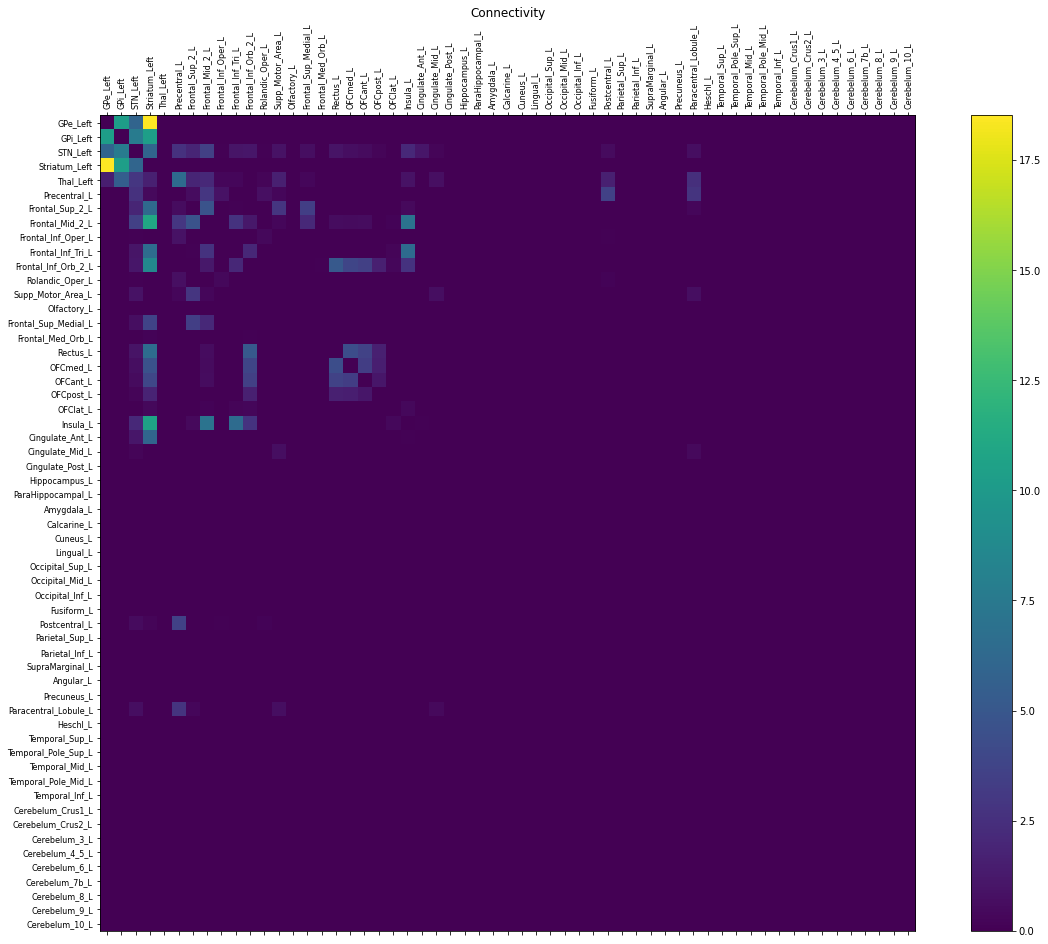

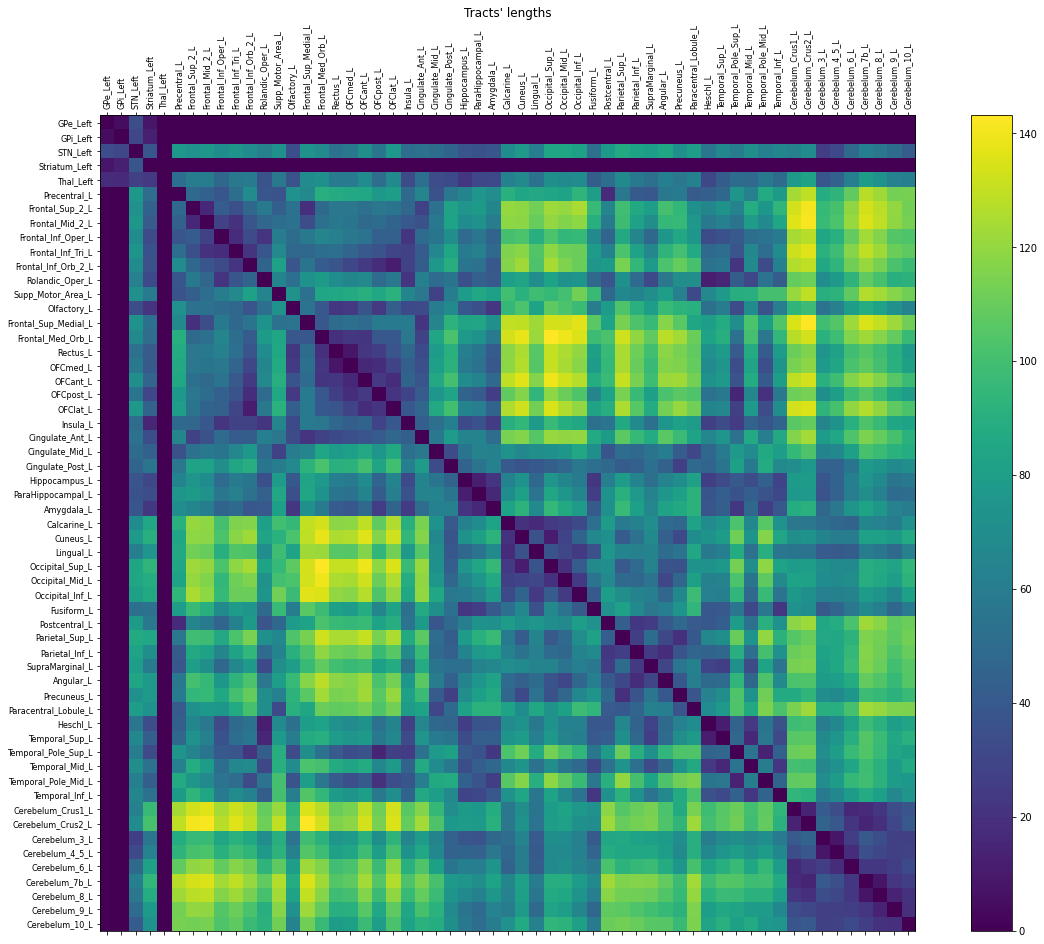

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove the second Thalamus, Pallidum (GPe/i), Putamen and Caudate (Striatum):
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
inds_Pall = (rlTVB.tolist().index("Pallidum_L"), rlTVB.tolist().index("Pallidum_R"))
inds_Put = (rlTVB.tolist().index("Putamen_L"), rlTVB.tolist().index("Putamen_R"))
inds_Caud = (rlTVB.tolist().index("Caudate_L"), rlTVB.tolist().index("Caudate_R"))
inds_rm = inds_Th + inds_Pall + inds_Put + inds_Caud
print("Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:\n", 
      wTVB[inds_rm, :][:, inds_rm])
wTVB = np.delete(wTVB, inds_rm, axis=0)
wTVB = np.delete(wTVB, inds_rm, axis=1)
tlTVB = np.delete(tlTVB, inds_rm, axis=0)
tlTVB = np.delete(tlTVB, inds_rm, axis=1)
rlTVB = np.delete(rlTVB, inds_rm, axis=0)
cTVB = np.delete(cTVB, inds_rm, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


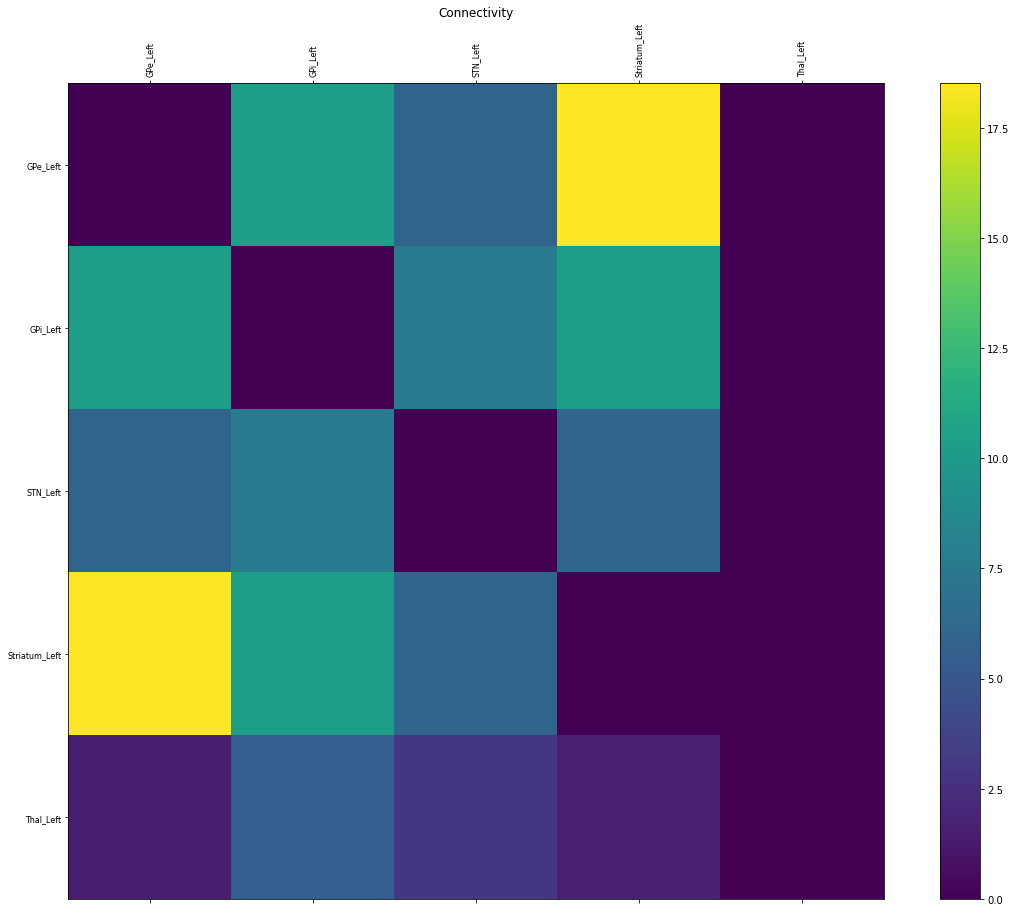

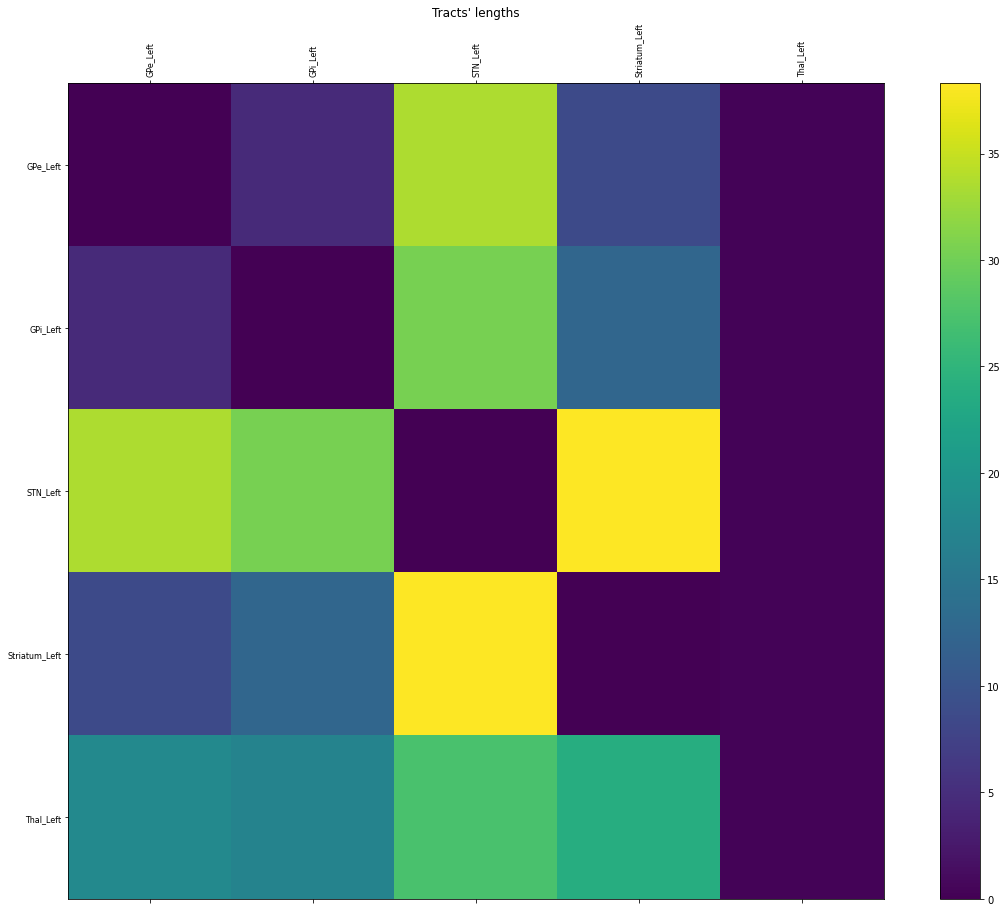

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.000709492



Left BG optimized network:


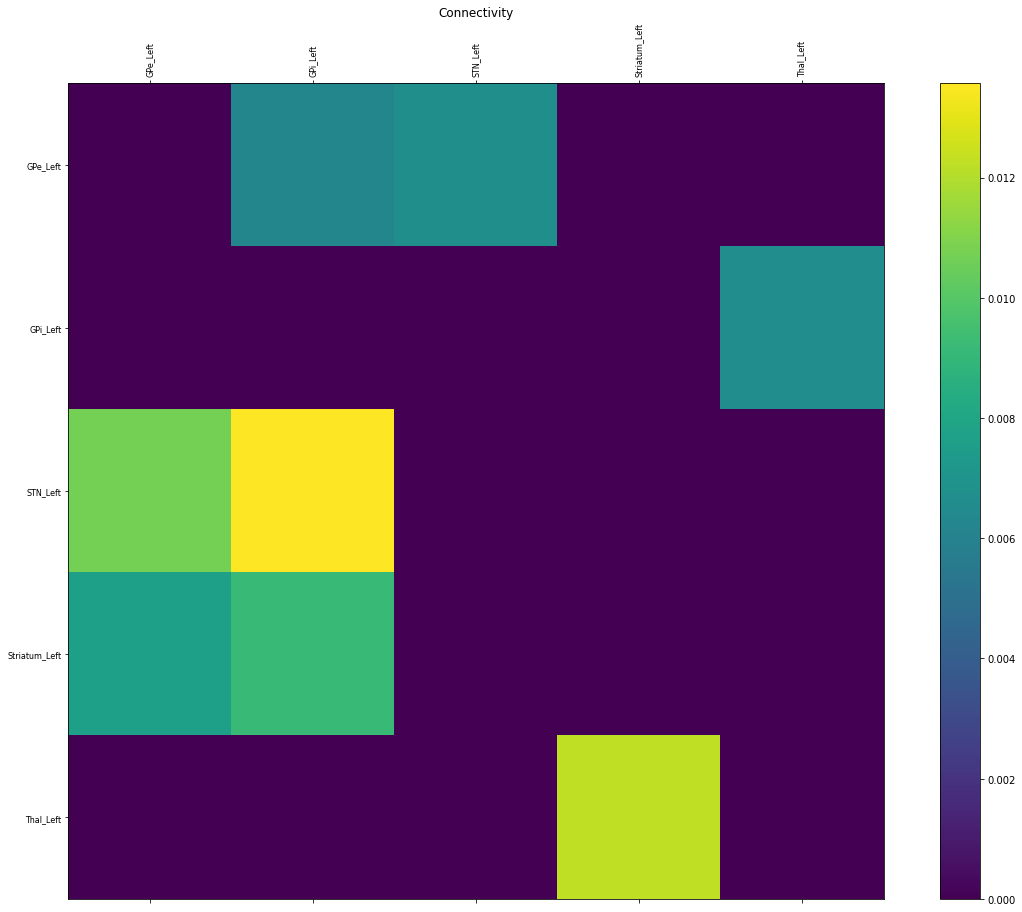

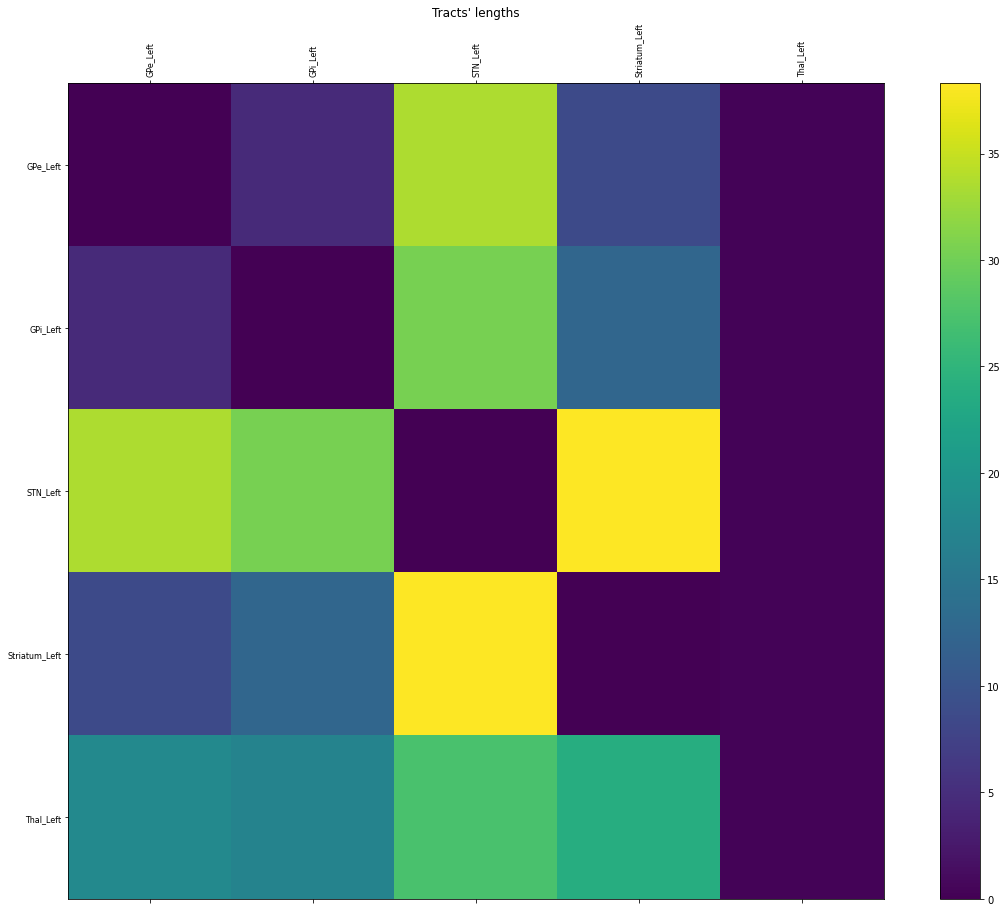

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


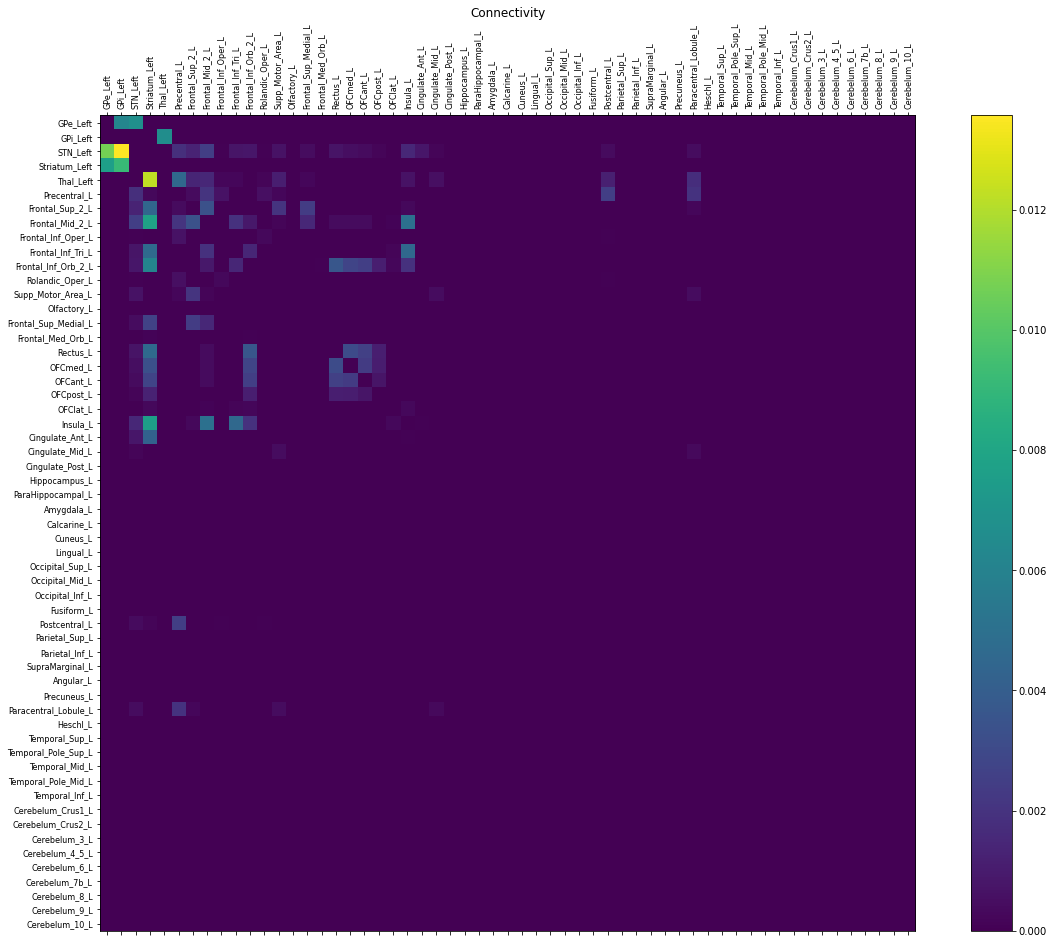

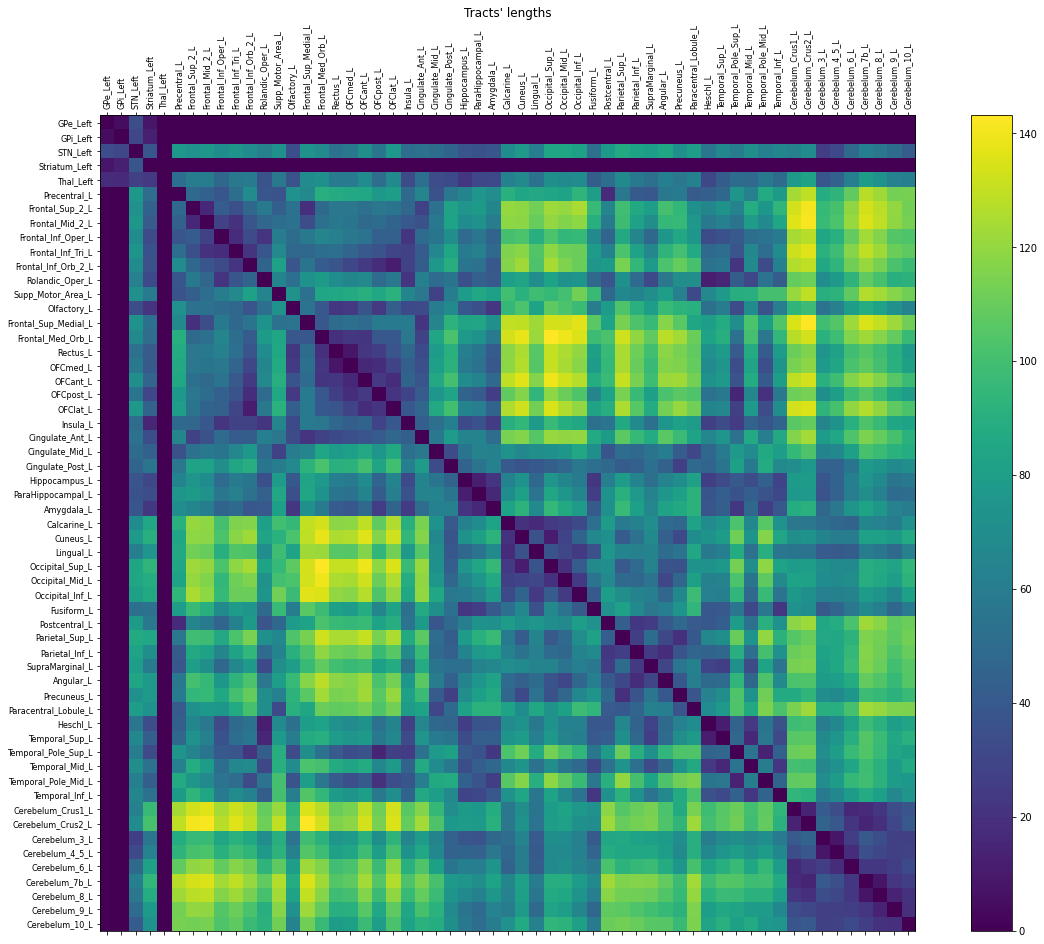

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {"G": np.array([15.0/scaleBGoptTOtvb])}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-5])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond_filepath = os.path.join(outputs_path, "tvb_init_cond_left.npy")
init_cond = np.load(init_cond_filepath)   # 
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [8]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config, set_defaults=False)



# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"v": -70.0, "u": -18.55, "E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5})   # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", 
             "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids}
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(), # wThdSN, # 
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids}
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"] + "_spikes"
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build_spiking_network()


ANNarchy 4.6 (4.6.9.9) on linux (posix). 
2021-03-10 14:31:05,134 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-10 14:31:05,134 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-10 14:31:05,143 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-10 14:31:05,143 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-10 14:31:06,457 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-10 14:31:06,457 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-10 14:31:06,471 - INFO - tvb_multiscale.co

In [9]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


In [10]:
# print(nest_network.print_str(connectivity=True))

## 3. Build the TVB-ANNarchy interface

In [11]:
from tvb_multiscale.tvb_annarchy.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_annarchy_builder = \
    RedWWexcIOBuilder(simulator, annarchy_network, spiking_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_annarchy_mode = "rate"
annarchy_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

# tvb_annarchy_builder.G = tvb_annarchy_builder.tvb_simulator.model.G[0].item()
# tvb_annarchy_builder.global_coupling_scaling = tvb_annarchy_builder.tvb_simulator.coupling.a[0].item() * tvb_annarchy_builder.G
tvb_annarchy_builder.global_coupling_scaling = 0.2

class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = tvb_annarchy_builder.global_coupling_scaling
    
    def __init__(self, scale=tvb_annarchy_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_annarchy_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_annarchy_builder.tvb_delays))

# Total TVB weight to STN:
wTVBSTNs = simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze()
wTVBSTN = wTVBSTNs.sum()
print("wTVBSTN = %g" % wTVBSTN)
# Total TVB weight to Striatum:
wTVBSNs = simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze()
wTVBSN = wTVBSNs.sum()
print("wTVBSN = %g" % wTVBSN)

iwCtxSTN = wCtxSTN / wTVBSTN
print("iwCtxSTN = %g" % iwCtxSTN)
print("wCtxSTN_effective = iwCtxSTN * wTVBSTN = %g = wCtxSTN = %g" % (iwCtxSTN * wTVBSTN, wCtxSTN))
# It has to be:
# # wCtxSTN / wCtxdSN = (iwCtxSTN * wTVBSTN) / (iwCtxdSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxdSN = wCtxdSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for dSN
iwCtxdSN = wCtxdSN / wTVBSN  # 10*
print("iwCtxdSN = %g" % iwCtxdSN)
print("wCtxdSN_effective = iwCtxdSN * wTVBSN = %g = wCtxdSN = %g" % (iwCtxdSN * wTVBSN, wCtxdSN))
# # wCtxSTN / wCtxiSN = (iwCtxSTN * wTVBSTN) / (iwCtxiSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxiSN = wCtxiSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for iSN
iwCtxiSN = wCtxiSN / wTVBSN  # 15* 
print("iwCtxiSN = %g" % iwCtxiSN)
print("wCtxiSN_effective = iwCtxiSN * wTVBSN = %g = wCtxiSN = %g" % (iwCtxiSN * wTVBSN, wCtxiSN))

tvb_annarchy_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_annarchy_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes, conn_scaling, this_conn_spec in zip(["E", "IdSN", "IiSN"],
                                                     [ann_model_builder.Estn_nodes_ids, 
                                                      ann_model_builder.Istr_nodes_ids, 
                                                      ann_model_builder.Istr_nodes_ids], 
                                                     [iwCtxSTN, iwCtxdSN, iwCtxiSN], # [wCtxSTN/52, wCtxdSN/52, wCtxiSN/52],
                                                     [conn_spec_fixed_prob(prob=pCtxSTN), # pCtxSTN  
                                                      conn_spec_fixed_prob(prob=pCtxdSN), # pCtxdSN
                                                      conn_spec_fixed_prob(prob=pCtxiSN)  # pCtxiSN
                                                      ]):          
        tvb_annarchy_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "PoissonPopulation", "params": {"geometry": 600, "record": ["spike"]}, # TimedArray
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 1.0,
        # Applied outside ANNarchy for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, annarchy_node_id=None)-----------
             "weights": TVBWeightFun(scale=conn_scaling*tvb_annarchy_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, annarchy_node_id: tvb_delay_fun(tvb_node_id, annarchy_node_id),
             "receptor_type": "ampa",
             "conn_spec": this_conn_spec,
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> ANNarchy population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if annarchy_to_tvb:
    tvb_annarchy_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- ANNarchy:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, ann_model_builder.Istr_nodes_ids]):
        #            TVB <- ANNarchy
        tvb_annarchy_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "SpikeMonitor", "params": {},
        # ------------------Properties potentially set as function handles with args (annarchy_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------                 #            TVB <- ANNarchy
        #                    TVB <- ANNarchy
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_annarchy_builder.w_tvb_to_spike_rate = 1.0
# We return from a ANNarchy SpikeMonitor the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_annarchy_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_annarchy_model = tvb_annarchy_builder.build_interface(tvb_to_annarchy_mode=tvb_to_annarchy_mode, annarchy_to_tvb=annarchy_to_tvb)


wTVBSTN = 0.0138205
wTVBSN = 0.0506763
iwCtxSTN = 0.928525
wCtxSTN_effective = iwCtxSTN * wTVBSTN = 0.0128327 = wCtxSTN = 0.0128327
iwCtxdSN = 0.194195
wCtxdSN_effective = iwCtxdSN * wTVBSN = 0.0098411 = wCtxdSN = 0.0098411
iwCtxiSN = 0.210571
wCtxiSN_effective = iwCtxiSN * wTVBSN = 0.010671 = wCtxiSN = 0.010671
2021-03-10 14:31:08,383 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:31:08,383 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:31:08,388 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:31:08,388 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:31:08,398 - INFO - tvb_multiscale.core.spiking_models.devices - 

In [12]:
# print(np.corrcoef(1000*np.array([simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids], 
#                       simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids]]).squeeze()))
# source_nodes_STN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_STN)
# source_nodes_SN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_SN)
# conns = np.array([simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Estn_nodes_ids],
#                   simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Istr_nodes_ids]]).T
# print(1000 * conns)
# print(np.corrcoef(conns.T))

## 3. Configure simulator, simulate, gather results

In [13]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))
print(annarchy_network.print_str(connectivity=True))
print(tvb_annarchy_model.print_str(detailed_output=True, connectivity=False))


Compiled! in 0.089949 min

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
ANNarchyNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
ANNarchyRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

ANNarchyPopulation - Label: I 
model: Spiking neuron
200 neurons in population with index: 0
parameters: {'a': array([0.005]), 'b': array([0.585]), 'c': array([-65.]), 'd': array(

In [14]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
simulation_length = 550.0
transient = 50.0 # simulation_length/11
# ...and simulate!
t_start = time.time()
simulator.configure(tvb_annarchy_model) # 

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = 200.0
    
results = simulator.run(simulation_length=simulation_length1, # 35.0 with stimulus application
                        configure_spiking_simulator=False)    # because compilation has already be done

if simulation_mode != "rs":
    # for stimulus application:
    if simulation_mode.find("STN") > -1:
        Istim = -50.0 
        region = "STN_Left" 
        pop = "E" 
    else:
        Istim = -25.0 
        region = "GPi_Left" 
        pop = "I" 
    annarchy_network.brain_regions[region][pop].Set(
        {"I": Istim + annarchy_network.brain_regions[region][pop].Get("I")["I"]})
    results2 = simulator.run(simulation_length=250.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    annarchy_network.brain_regions[region][pop].Set(
        {"I": annarchy_network.brain_regions[region][pop].Get("I")["I"] - Istim})
    results3 = simulator.run(simulation_length=100.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0], results3[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1], results3[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))

Simulating 0.0001 seconds of the network took 0.0031054019927978516 seconds. 
Simulating 0.0001 seconds of the network took 0.002159595489501953 seconds. 
Simulating 0.0001 seconds of the network took 0.0015256404876708984 seconds. 
Simulating 0.0001 seconds of the network took 0.001683950424194336 seconds. 
Simulating 0.0001 seconds of the network took 0.0020051002502441406 seconds. 
Simulating 0.0001 seconds of the network took 0.0020520687103271484 seconds. 
Simulating 0.0001 seconds of the network took 0.0018842220306396484 seconds. 
Simulating 0.0001 seconds of the network took 0.0013375282287597656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016107559204101562 seconds. 
Simulating 0.0001 seconds of the network took 0.0019376277923583984 seconds. 
Simulating 0.0001 seconds of the network took 0.002065420150756836 seconds. 
Simulating 0.0001 seconds of the network took 0.001687765121459961 seconds. 
Simulating 0.0001 seconds of the network took 0.0017306804656982422 

Simulating 0.0001 seconds of the network took 0.0016207695007324219 seconds. 
Simulating 0.0001 seconds of the network took 0.0018191337585449219 seconds. 
Simulating 0.0001 seconds of the network took 0.002111673355102539 seconds. 
Simulating 0.0001 seconds of the network took 0.001466989517211914 seconds. 
Simulating 0.0001 seconds of the network took 0.0013537406921386719 seconds. 
Simulating 0.0001 seconds of the network took 0.0019271373748779297 seconds. 
Simulating 0.0001 seconds of the network took 0.0014214515686035156 seconds. 
Simulating 0.0001 seconds of the network took 0.0013587474822998047 seconds. 
Simulating 0.0001 seconds of the network took 0.0015673637390136719 seconds. 
Simulating 0.0001 seconds of the network took 0.0022568702697753906 seconds. 
Simulating 0.0001 seconds of the network took 0.0037670135498046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0024433135986328125 seconds. 
Simulating 0.0001 seconds of the network took 0.002357721328735351

Simulating 0.0001 seconds of the network took 0.001766204833984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015897750854492188 seconds. 
Simulating 0.0001 seconds of the network took 0.0013027191162109375 seconds. 
Simulating 0.0001 seconds of the network took 0.0013637542724609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015015602111816406 seconds. 
Simulating 0.0001 seconds of the network took 0.002198934555053711 seconds. 
Simulating 0.0001 seconds of the network took 0.0017676353454589844 seconds. 
Simulating 0.0001 seconds of the network took 0.0015308856964111328 seconds. 
Simulating 0.0001 seconds of the network took 0.0013811588287353516 seconds. 
Simulating 0.0001 seconds of the network took 0.0013301372528076172 seconds. 
Simulating 0.0001 seconds of the network took 0.0015926361083984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0017392635345458984 seconds. 
Simulating 0.0001 seconds of the network took 0.001691579818725586

Simulating 0.0001 seconds of the network took 0.0018656253814697266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017864704132080078 seconds. 
Simulating 0.0001 seconds of the network took 0.001617431640625 seconds. 
Simulating 0.0001 seconds of the network took 0.0014920234680175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0013916492462158203 seconds. 
Simulating 0.0001 seconds of the network took 0.0019297599792480469 seconds. 
Simulating 0.0001 seconds of the network took 0.0019392967224121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0014941692352294922 seconds. 
Simulating 0.0001 seconds of the network took 0.0015308856964111328 seconds. 
Simulating 0.0001 seconds of the network took 0.0016674995422363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0018084049224853516 seconds. 
Simulating 0.0001 seconds of the network took 0.0026907920837402344 seconds. 
Simulating 0.0001 seconds of the network took 0.001638650894165039 s

Simulating 0.0001 seconds of the network took 0.002044677734375 seconds. 
Simulating 0.0001 seconds of the network took 0.001695394515991211 seconds. 
Simulating 0.0001 seconds of the network took 0.001543283462524414 seconds. 
Simulating 0.0001 seconds of the network took 0.002237558364868164 seconds. 
Simulating 0.0001 seconds of the network took 0.0046291351318359375 seconds. 
Simulating 0.0001 seconds of the network took 0.0019254684448242188 seconds. 
Simulating 0.0001 seconds of the network took 0.0013344287872314453 seconds. 
Simulating 0.0001 seconds of the network took 0.0017316341400146484 seconds. 
Simulating 0.0001 seconds of the network took 0.002170085906982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0018188953399658203 seconds. 
Simulating 0.0001 seconds of the network took 0.0014641284942626953 seconds. 
Simulating 0.0001 seconds of the network took 0.0017976760864257812 seconds. 
Simulating 0.0001 seconds of the network took 0.0017430782318115234 seco

Simulating 0.0001 seconds of the network took 0.0018489360809326172 seconds. 
Simulating 0.0001 seconds of the network took 0.0018475055694580078 seconds. 
Simulating 0.0001 seconds of the network took 0.0013484954833984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0017123222351074219 seconds. 
Simulating 0.0001 seconds of the network took 0.0016293525695800781 seconds. 
Simulating 0.0001 seconds of the network took 0.0014109611511230469 seconds. 
Simulating 0.0001 seconds of the network took 0.0019075870513916016 seconds. 
Simulating 0.0001 seconds of the network took 0.0017292499542236328 seconds. 
Simulating 0.0001 seconds of the network took 0.0014166831970214844 seconds. 
Simulating 0.0001 seconds of the network took 0.0020346641540527344 seconds. 
Simulating 0.0001 seconds of the network took 0.001955270767211914 seconds. 
...10.0% done in 28.2 sec
Simulating 0.0001 seconds of the network took 0.0014963150024414062 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.0019037723541259766 seconds. 
Simulating 0.0001 seconds of the network took 0.0016276836395263672 seconds. 
Simulating 0.0001 seconds of the network took 0.0016360282897949219 seconds. 
Simulating 0.0001 seconds of the network took 0.0018486976623535156 seconds. 
Simulating 0.0001 seconds of the network took 0.0016531944274902344 seconds. 
Simulating 0.0001 seconds of the network took 0.002158641815185547 seconds. 
Simulating 0.0001 seconds of the network took 0.0018079280853271484 seconds. 
Simulating 0.0001 seconds of the network took 0.0013959407806396484 seconds. 
Simulating 0.0001 seconds of the network took 0.00140380859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0018610954284667969 seconds. 
Simulating 0.0001 seconds of the network took 0.001538991928100586 seconds. 
Simulating 0.0001 seconds of the network took 0.0018107891082763672 seconds. 
Simulating 0.0001 seconds of the network took 0.001417398452758789 seco

Simulating 0.0001 seconds of the network took 0.00267791748046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0018701553344726562 seconds. 
Simulating 0.0001 seconds of the network took 0.0015368461608886719 seconds. 
Simulating 0.0001 seconds of the network took 0.0013628005981445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0016796588897705078 seconds. 
Simulating 0.0001 seconds of the network took 0.0019354820251464844 seconds. 
Simulating 0.0001 seconds of the network took 0.0014166831970214844 seconds. 
Simulating 0.0001 seconds of the network took 0.0019729137420654297 seconds. 
Simulating 0.0001 seconds of the network took 0.0017266273498535156 seconds. 
Simulating 0.0001 seconds of the network took 0.0020911693572998047 seconds. 
Simulating 0.0001 seconds of the network took 0.001935720443725586 seconds. 
Simulating 0.0001 seconds of the network took 0.0019421577453613281 seconds. 
Simulating 0.0001 seconds of the network took 0.001409769058227539 

Simulating 0.0001 seconds of the network took 0.0017745494842529297 seconds. 
Simulating 0.0001 seconds of the network took 0.0018856525421142578 seconds. 
Simulating 0.0001 seconds of the network took 0.001398324966430664 seconds. 
Simulating 0.0001 seconds of the network took 0.001665353775024414 seconds. 
Simulating 0.0001 seconds of the network took 0.0013911724090576172 seconds. 
Simulating 0.0001 seconds of the network took 0.0031538009643554688 seconds. 
Simulating 0.0001 seconds of the network took 0.002629995346069336 seconds. 
Simulating 0.0001 seconds of the network took 0.0016360282897949219 seconds. 
Simulating 0.0001 seconds of the network took 0.0016620159149169922 seconds. 
Simulating 0.0001 seconds of the network took 0.0018305778503417969 seconds. 
Simulating 0.0001 seconds of the network took 0.0017848014831542969 seconds. 
Simulating 0.0001 seconds of the network took 0.0014209747314453125 seconds. 
Simulating 0.0001 seconds of the network took 0.001928091049194336 

Simulating 0.0001 seconds of the network took 0.001880645751953125 seconds. 
Simulating 0.0001 seconds of the network took 0.0013742446899414062 seconds. 
Simulating 0.0001 seconds of the network took 0.0013349056243896484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016086101531982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0013966560363769531 seconds. 
Simulating 0.0001 seconds of the network took 0.0019273757934570312 seconds. 
Simulating 0.0001 seconds of the network took 0.0018613338470458984 seconds. 
Simulating 0.0001 seconds of the network took 0.001760244369506836 seconds. 
Simulating 0.0001 seconds of the network took 0.0014216899871826172 seconds. 
Simulating 0.0001 seconds of the network took 0.0013413429260253906 seconds. 
Simulating 0.0001 seconds of the network took 0.0019998550415039062 seconds. 
Simulating 0.0001 seconds of the network took 0.0015909671783447266 seconds. 
Simulating 0.0001 seconds of the network took 0.001798152923583984

Simulating 0.0001 seconds of the network took 0.002068758010864258 seconds. 
Simulating 0.0001 seconds of the network took 0.0014853477478027344 seconds. 
Simulating 0.0001 seconds of the network took 0.001462697982788086 seconds. 
Simulating 0.0001 seconds of the network took 0.0017375946044921875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016553401947021484 seconds. 
Simulating 0.0001 seconds of the network took 0.0014803409576416016 seconds. 
Simulating 0.0001 seconds of the network took 0.0018036365509033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016942024230957031 seconds. 
Simulating 0.0001 seconds of the network took 0.0018894672393798828 seconds. 
Simulating 0.0001 seconds of the network took 0.0014958381652832031 seconds. 
Simulating 0.0001 seconds of the network took 0.0019922256469726562 seconds. 
Simulating 0.0001 seconds of the network took 0.0017707347869873047 seconds. 
Simulating 0.0001 seconds of the network took 0.001580476760864257

Simulating 0.0001 seconds of the network took 0.0017635822296142578 seconds. 
Simulating 0.0001 seconds of the network took 0.0017254352569580078 seconds. 
Simulating 0.0001 seconds of the network took 0.0014472007751464844 seconds. 
Simulating 0.0001 seconds of the network took 0.00150299072265625 seconds. 
Simulating 0.0001 seconds of the network took 0.0013971328735351562 seconds. 
Simulating 0.0001 seconds of the network took 0.001703023910522461 seconds. 
Simulating 0.0001 seconds of the network took 0.0019214153289794922 seconds. 
Simulating 0.0001 seconds of the network took 0.0013582706451416016 seconds. 
Simulating 0.0001 seconds of the network took 0.0014920234680175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0015037059783935547 seconds. 
Simulating 0.0001 seconds of the network took 0.0016963481903076172 seconds. 
Simulating 0.0001 seconds of the network took 0.0014758110046386719 seconds. 
Simulating 0.0001 seconds of the network took 0.0013191699981689453

Simulating 0.0001 seconds of the network took 0.0020165443420410156 seconds. 
Simulating 0.0001 seconds of the network took 0.0016548633575439453 seconds. 
Simulating 0.0001 seconds of the network took 0.0018320083618164062 seconds. 
Simulating 0.0001 seconds of the network took 0.002022981643676758 seconds. 
Simulating 0.0001 seconds of the network took 0.0016798973083496094 seconds. 
Simulating 0.0001 seconds of the network took 0.0019409656524658203 seconds. 
Simulating 0.0001 seconds of the network took 0.0014157295227050781 seconds. 
Simulating 0.0001 seconds of the network took 0.0017821788787841797 seconds. 
Simulating 0.0001 seconds of the network took 0.0015358924865722656 seconds. 
Simulating 0.0001 seconds of the network took 0.0015139579772949219 seconds. 
Simulating 0.0001 seconds of the network took 0.0014460086822509766 seconds. 
Simulating 0.0001 seconds of the network took 0.0019774436950683594 seconds. 
Simulating 0.0001 seconds of the network took 0.00185704231262207

Simulating 0.0001 seconds of the network took 0.0018630027770996094 seconds. 
Simulating 0.0001 seconds of the network took 0.001737356185913086 seconds. 
Simulating 0.0001 seconds of the network took 0.001708984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0019397735595703125 seconds. 
Simulating 0.0001 seconds of the network took 0.0018200874328613281 seconds. 
Simulating 0.0001 seconds of the network took 0.0019989013671875 seconds. 
Simulating 0.0001 seconds of the network took 0.001695394515991211 seconds. 
Simulating 0.0001 seconds of the network took 0.0019366741180419922 seconds. 
Simulating 0.0001 seconds of the network took 0.0018961429595947266 seconds. 
Simulating 0.0001 seconds of the network took 0.0020346641540527344 seconds. 
Simulating 0.0001 seconds of the network took 0.001710653305053711 seconds. 
Simulating 0.0001 seconds of the network took 0.0015797615051269531 seconds. 
Simulating 0.0001 seconds of the network took 0.0014727115631103516 seconds. 

Simulating 0.0001 seconds of the network took 0.0021076202392578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0019249916076660156 seconds. 
Simulating 0.0001 seconds of the network took 0.0021119117736816406 seconds. 
Simulating 0.0001 seconds of the network took 0.0022368431091308594 seconds. 
Simulating 0.0001 seconds of the network took 0.0020902156829833984 seconds. 
Simulating 0.0001 seconds of the network took 0.0019669532775878906 seconds. 
Simulating 0.0001 seconds of the network took 0.0019164085388183594 seconds. 
Simulating 0.0001 seconds of the network took 0.0019195079803466797 seconds. 
Simulating 0.0001 seconds of the network took 0.0019936561584472656 seconds. 
Simulating 0.0001 seconds of the network took 0.0019381046295166016 seconds. 
Simulating 0.0001 seconds of the network took 0.002367734909057617 seconds. 
Simulating 0.0001 seconds of the network took 0.0019006729125976562 seconds. 
Simulating 0.0001 seconds of the network took 0.00203752517700195

Simulating 0.0001 seconds of the network took 0.0020623207092285156 seconds. 
Simulating 0.0001 seconds of the network took 0.0020558834075927734 seconds. 
Simulating 0.0001 seconds of the network took 0.001918792724609375 seconds. 
Simulating 0.0001 seconds of the network took 0.002224445343017578 seconds. 
Simulating 0.0001 seconds of the network took 0.0022509098052978516 seconds. 
Simulating 0.0001 seconds of the network took 0.001829385757446289 seconds. 
Simulating 0.0001 seconds of the network took 0.0016214847564697266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017366409301757812 seconds. 
Simulating 0.0001 seconds of the network took 0.0021262168884277344 seconds. 
Simulating 0.0001 seconds of the network took 0.0022735595703125 seconds. 
Simulating 0.0001 seconds of the network took 0.0020394325256347656 seconds. 
Simulating 0.0001 seconds of the network took 0.0015528202056884766 seconds. 
Simulating 0.0001 seconds of the network took 0.002004384994506836 sec

Simulating 0.0001 seconds of the network took 0.0020394325256347656 seconds. 
Simulating 0.0001 seconds of the network took 0.002071380615234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0025632381439208984 seconds. 
Simulating 0.0001 seconds of the network took 0.002871990203857422 seconds. 
Simulating 0.0001 seconds of the network took 0.001997709274291992 seconds. 
Simulating 0.0001 seconds of the network took 0.0021271705627441406 seconds. 
Simulating 0.0001 seconds of the network took 0.0022826194763183594 seconds. 
Simulating 0.0001 seconds of the network took 0.002336740493774414 seconds. 
Simulating 0.0001 seconds of the network took 0.002063751220703125 seconds. 
Simulating 0.0001 seconds of the network took 0.0022950172424316406 seconds. 
Simulating 0.0001 seconds of the network took 0.001966238021850586 seconds. 
Simulating 0.0001 seconds of the network took 0.0021545886993408203 seconds. 
Simulating 0.0001 seconds of the network took 0.0019009113311767578 se

Simulating 0.0001 seconds of the network took 0.002253293991088867 seconds. 
Simulating 0.0001 seconds of the network took 0.0018911361694335938 seconds. 
Simulating 0.0001 seconds of the network took 0.00186920166015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017325878143310547 seconds. 
Simulating 0.0001 seconds of the network took 0.0021047592163085938 seconds. 
Simulating 0.0001 seconds of the network took 0.0018303394317626953 seconds. 
Simulating 0.0001 seconds of the network took 0.0017926692962646484 seconds. 
Simulating 0.0001 seconds of the network took 0.0017778873443603516 seconds. 
Simulating 0.0001 seconds of the network took 0.0017507076263427734 seconds. 
Simulating 0.0001 seconds of the network took 0.0019445419311523438 seconds. 
Simulating 0.0001 seconds of the network took 0.0016717910766601562 seconds. 
Simulating 0.0001 seconds of the network took 0.0017976760864257812 seconds. 
Simulating 0.0001 seconds of the network took 0.0019497871398925781

Simulating 0.0001 seconds of the network took 0.002054929733276367 seconds. 
Simulating 0.0001 seconds of the network took 0.001741170883178711 seconds. 
Simulating 0.0001 seconds of the network took 0.0018360614776611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0015811920166015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0020012855529785156 seconds. 
Simulating 0.0001 seconds of the network took 0.0018765926361083984 seconds. 
Simulating 0.0001 seconds of the network took 0.001676797866821289 seconds. 
Simulating 0.0001 seconds of the network took 0.0016887187957763672 seconds. 
Simulating 0.0001 seconds of the network took 0.002131223678588867 seconds. 
Simulating 0.0001 seconds of the network took 0.001352071762084961 seconds. 
Simulating 0.0001 seconds of the network took 0.0013818740844726562 seconds. 
Simulating 0.0001 seconds of the network took 0.001745462417602539 seconds. 
Simulating 0.0001 seconds of the network took 0.0013039112091064453 se

Simulating 0.0001 seconds of the network took 0.0018298625946044922 seconds. 
Simulating 0.0001 seconds of the network took 0.001840829849243164 seconds. 
Simulating 0.0001 seconds of the network took 0.0016787052154541016 seconds. 
Simulating 0.0001 seconds of the network took 0.0013213157653808594 seconds. 
Simulating 0.0001 seconds of the network took 0.001718282699584961 seconds. 
Simulating 0.0001 seconds of the network took 0.0019075870513916016 seconds. 
Simulating 0.0001 seconds of the network took 0.0017371177673339844 seconds. 
Simulating 0.0001 seconds of the network took 0.0016245841979980469 seconds. 
Simulating 0.0001 seconds of the network took 0.0016636848449707031 seconds. 
Simulating 0.0001 seconds of the network took 0.0016176700592041016 seconds. 
Simulating 0.0001 seconds of the network took 0.0015206336975097656 seconds. 
Simulating 0.0001 seconds of the network took 0.0017926692962646484 seconds. 
Simulating 0.0001 seconds of the network took 0.002171993255615234

Simulating 0.0001 seconds of the network took 0.001430511474609375 seconds. 
Simulating 0.0001 seconds of the network took 0.001992940902709961 seconds. 
Simulating 0.0001 seconds of the network took 0.0014452934265136719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016164779663085938 seconds. 
Simulating 0.0001 seconds of the network took 0.001852273941040039 seconds. 
Simulating 0.0001 seconds of the network took 0.0014984607696533203 seconds. 
Simulating 0.0001 seconds of the network took 0.0019233226776123047 seconds. 
Simulating 0.0001 seconds of the network took 0.0019276142120361328 seconds. 
Simulating 0.0001 seconds of the network took 0.0014853477478027344 seconds. 
Simulating 0.0001 seconds of the network took 0.0013120174407958984 seconds. 
Simulating 0.0001 seconds of the network took 0.0019431114196777344 seconds. 
Simulating 0.0001 seconds of the network took 0.0019490718841552734 seconds. 
Simulating 0.0001 seconds of the network took 0.001378774642944336 

Simulating 0.0001 seconds of the network took 0.0017108917236328125 seconds. 
Simulating 0.0001 seconds of the network took 0.0019500255584716797 seconds. 
Simulating 0.0001 seconds of the network took 0.001332998275756836 seconds. 
Simulating 0.0001 seconds of the network took 0.001760244369506836 seconds. 
Simulating 0.0001 seconds of the network took 0.001538991928100586 seconds. 
Simulating 0.0001 seconds of the network took 0.0015990734100341797 seconds. 
Simulating 0.0001 seconds of the network took 0.0017428398132324219 seconds. 
Simulating 0.0001 seconds of the network took 0.0014085769653320312 seconds. 
Simulating 0.0001 seconds of the network took 0.001409769058227539 seconds. 
Simulating 0.0001 seconds of the network took 0.0013866424560546875 seconds. 
Simulating 0.0001 seconds of the network took 0.001605987548828125 seconds. 
Simulating 0.0001 seconds of the network took 0.001405954360961914 seconds. 
Simulating 0.0001 seconds of the network took 0.001338958740234375 sec

Simulating 0.0001 seconds of the network took 0.00135040283203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017039775848388672 seconds. 
Simulating 0.0001 seconds of the network took 0.0014209747314453125 seconds. 
Simulating 0.0001 seconds of the network took 0.0025136470794677734 seconds. 
Simulating 0.0001 seconds of the network took 0.0016021728515625 seconds. 
Simulating 0.0001 seconds of the network took 0.0019822120666503906 seconds. 
Simulating 0.0001 seconds of the network took 0.001547098159790039 seconds. 
Simulating 0.0001 seconds of the network took 0.0018525123596191406 seconds. 
Simulating 0.0001 seconds of the network took 0.0014221668243408203 seconds. 
Simulating 0.0001 seconds of the network took 0.0018610954284667969 seconds. 
Simulating 0.0001 seconds of the network took 0.0017313957214355469 seconds. 
Simulating 0.0001 seconds of the network took 0.003522157669067383 seconds. 
Simulating 0.0001 seconds of the network took 0.001842498779296875 seco

Simulating 0.0001 seconds of the network took 0.0018613338470458984 seconds. 
Simulating 0.0001 seconds of the network took 0.0018031597137451172 seconds. 
Simulating 0.0001 seconds of the network took 0.0014982223510742188 seconds. 
Simulating 0.0001 seconds of the network took 0.0015788078308105469 seconds. 
Simulating 0.0001 seconds of the network took 0.0013973712921142578 seconds. 
Simulating 0.0001 seconds of the network took 0.0019185543060302734 seconds. 
Simulating 0.0001 seconds of the network took 0.0013301372528076172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016205310821533203 seconds. 
Simulating 0.0001 seconds of the network took 0.0013895034790039062 seconds. 
Simulating 0.0001 seconds of the network took 0.0014925003051757812 seconds. 
Simulating 0.0001 seconds of the network took 0.0016694068908691406 seconds. 
Simulating 0.0001 seconds of the network took 0.0017592906951904297 seconds. 
Simulating 0.0001 seconds of the network took 0.0015637874603271

Simulating 0.0001 seconds of the network took 0.001898050308227539 seconds. 
Simulating 0.0001 seconds of the network took 0.0017664432525634766 seconds. 
Simulating 0.0001 seconds of the network took 0.001478433609008789 seconds. 
Simulating 0.0001 seconds of the network took 0.0016508102416992188 seconds. 
Simulating 0.0001 seconds of the network took 0.001989126205444336 seconds. 
Simulating 0.0001 seconds of the network took 0.0017695426940917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0019338130950927734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015761852264404297 seconds. 
Simulating 0.0001 seconds of the network took 0.001781463623046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0014600753784179688 seconds. 
Simulating 0.0001 seconds of the network took 0.0018737316131591797 seconds. 
Simulating 0.0001 seconds of the network took 0.002032041549682617 seconds. 
Simulating 0.0001 seconds of the network took 0.0013599395751953125 s

Simulating 0.0001 seconds of the network took 0.0018773078918457031 seconds. 
Simulating 0.0001 seconds of the network took 0.001354217529296875 seconds. 
Simulating 0.0001 seconds of the network took 0.0020325183868408203 seconds. 
Simulating 0.0001 seconds of the network took 0.0014042854309082031 seconds. 
Simulating 0.0001 seconds of the network took 0.0015468597412109375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015583038330078125 seconds. 
Simulating 0.0001 seconds of the network took 0.001970529556274414 seconds. 
Simulating 0.0001 seconds of the network took 0.0013289451599121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0016150474548339844 seconds. 
Simulating 0.0001 seconds of the network took 0.0014183521270751953 seconds. 
Simulating 0.0001 seconds of the network took 0.0018393993377685547 seconds. 
Simulating 0.0001 seconds of the network took 0.0017843246459960938 seconds. 
Simulating 0.0001 seconds of the network took 0.001388072967529296

Simulating 0.0001 seconds of the network took 0.0023822784423828125 seconds. 
Simulating 0.0001 seconds of the network took 0.0015442371368408203 seconds. 
Simulating 0.0001 seconds of the network took 0.001531362533569336 seconds. 
Simulating 0.0001 seconds of the network took 0.0014116764068603516 seconds. 
Simulating 0.0001 seconds of the network took 0.0015685558319091797 seconds. 
Simulating 0.0001 seconds of the network took 0.00171661376953125 seconds. 
Simulating 0.0001 seconds of the network took 0.0018076896667480469 seconds. 
Simulating 0.0001 seconds of the network took 0.0014002323150634766 seconds. 
Simulating 0.0001 seconds of the network took 0.0013630390167236328 seconds. 
Simulating 0.0001 seconds of the network took 0.0014235973358154297 seconds. 
Simulating 0.0001 seconds of the network took 0.0017695426940917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0017552375793457031 seconds. 
Simulating 0.0001 seconds of the network took 0.0013477802276611328

Simulating 0.0001 seconds of the network took 0.0015056133270263672 seconds. 
Simulating 0.0001 seconds of the network took 0.0018739700317382812 seconds. 
Simulating 0.0001 seconds of the network took 0.0013775825500488281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015120506286621094 seconds. 
Simulating 0.0001 seconds of the network took 0.0025970935821533203 seconds. 
Simulating 0.0001 seconds of the network took 0.0018069744110107422 seconds. 
Simulating 0.0001 seconds of the network took 0.0016696453094482422 seconds. 
Simulating 0.0001 seconds of the network took 0.0013582706451416016 seconds. 
Simulating 0.0001 seconds of the network took 0.0015368461608886719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016367435455322266 seconds. 
Simulating 0.0001 seconds of the network took 0.0014965534210205078 seconds. 
Simulating 0.0001 seconds of the network took 0.001779317855834961 seconds. 
Simulating 0.0001 seconds of the network took 0.00140666961669921

Simulating 0.0001 seconds of the network took 0.0015630722045898438 seconds. 
Simulating 0.0001 seconds of the network took 0.0017459392547607422 seconds. 
Simulating 0.0001 seconds of the network took 0.0013604164123535156 seconds. 
Simulating 0.0001 seconds of the network took 0.0015287399291992188 seconds. 
Simulating 0.0001 seconds of the network took 0.0016217231750488281 seconds. 
Simulating 0.0001 seconds of the network took 0.0017218589782714844 seconds. 
Simulating 0.0001 seconds of the network took 0.0015516281127929688 seconds. 
Simulating 0.0001 seconds of the network took 0.0013599395751953125 seconds. 
Simulating 0.0001 seconds of the network took 0.001374959945678711 seconds. 
Simulating 0.0001 seconds of the network took 0.0013959407806396484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016362667083740234 seconds. 
Simulating 0.0001 seconds of the network took 0.00162506103515625 seconds. 
Simulating 0.0001 seconds of the network took 0.0013704299926757812

Simulating 0.0001 seconds of the network took 0.0015990734100341797 seconds. 
Simulating 0.0001 seconds of the network took 0.0019829273223876953 seconds. 
Simulating 0.0001 seconds of the network took 0.0016794204711914062 seconds. 
Simulating 0.0001 seconds of the network took 0.0014150142669677734 seconds. 
Simulating 0.0001 seconds of the network took 0.0014498233795166016 seconds. 
Simulating 0.0001 seconds of the network took 0.0016179084777832031 seconds. 
Simulating 0.0001 seconds of the network took 0.0017306804656982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0014171600341796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016150474548339844 seconds. 
Simulating 0.0001 seconds of the network took 0.0013401508331298828 seconds. 
Simulating 0.0001 seconds of the network took 0.0018353462219238281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016832351684570312 seconds. 
Simulating 0.0001 seconds of the network took 0.0016200542449951

Simulating 0.0001 seconds of the network took 0.0016815662384033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016376972198486328 seconds. 
Simulating 0.0001 seconds of the network took 0.0013668537139892578 seconds. 
Simulating 0.0001 seconds of the network took 0.0017015933990478516 seconds. 
Simulating 0.0001 seconds of the network took 0.001392364501953125 seconds. 
Simulating 0.0001 seconds of the network took 0.002947092056274414 seconds. 
Simulating 0.0001 seconds of the network took 0.0017695426940917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0015468597412109375 seconds. 
Simulating 0.0001 seconds of the network took 0.0013394355773925781 seconds. 
Simulating 0.0001 seconds of the network took 0.0013325214385986328 seconds. 
Simulating 0.0001 seconds of the network took 0.0020837783813476562 seconds. 
Simulating 0.0001 seconds of the network took 0.0016620159149169922 seconds. 
Simulating 0.0001 seconds of the network took 0.001718759536743164

Simulating 0.0001 seconds of the network took 0.0014891624450683594 seconds. 
Simulating 0.0001 seconds of the network took 0.0018496513366699219 seconds. 
Simulating 0.0001 seconds of the network took 0.0013625621795654297 seconds. 
Simulating 0.0001 seconds of the network took 0.0016930103302001953 seconds. 
Simulating 0.0001 seconds of the network took 0.0013494491577148438 seconds. 
Simulating 0.0001 seconds of the network took 0.0015106201171875 seconds. 
Simulating 0.0001 seconds of the network took 0.0018749237060546875 seconds. 
Simulating 0.0001 seconds of the network took 0.002351522445678711 seconds. 
Simulating 0.0001 seconds of the network took 0.0013885498046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0015404224395751953 seconds. 
Simulating 0.0001 seconds of the network took 0.0013780593872070312 seconds. 
Simulating 0.0001 seconds of the network took 0.00201416015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0013575553894042969 seconds.

Simulating 0.0001 seconds of the network took 0.0018124580383300781 seconds. 
Simulating 0.0001 seconds of the network took 0.001678466796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0013096332550048828 seconds. 
Simulating 0.0001 seconds of the network took 0.0015757083892822266 seconds. 
Simulating 0.0001 seconds of the network took 0.0014848709106445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0017986297607421875 seconds. 
Simulating 0.0001 seconds of the network took 0.0017414093017578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0014042854309082031 seconds. 
Simulating 0.0001 seconds of the network took 0.0013802051544189453 seconds. 
Simulating 0.0001 seconds of the network took 0.0014293193817138672 seconds. 
Simulating 0.0001 seconds of the network took 0.001401662826538086 seconds. 
Simulating 0.0001 seconds of the network took 0.001519918441772461 seconds. 
Simulating 0.0001 seconds of the network took 0.0015611648559570312 se

Simulating 0.0001 seconds of the network took 0.001443624496459961 seconds. 
Simulating 0.0001 seconds of the network took 0.0019443035125732422 seconds. 
Simulating 0.0001 seconds of the network took 0.0013768672943115234 seconds. 
Simulating 0.0001 seconds of the network took 0.001459360122680664 seconds. 
Simulating 0.0001 seconds of the network took 0.0013051033020019531 seconds. 
Simulating 0.0001 seconds of the network took 0.0014567375183105469 seconds. 
Simulating 0.0001 seconds of the network took 0.0015168190002441406 seconds. 
Simulating 0.0001 seconds of the network took 0.0014674663543701172 seconds. 
Simulating 0.0001 seconds of the network took 0.0017499923706054688 seconds. 
Simulating 0.0001 seconds of the network took 0.002184152603149414 seconds. 
Simulating 0.0001 seconds of the network took 0.001592397689819336 seconds. 
Simulating 0.0001 seconds of the network took 0.0018055438995361328 seconds. 
Simulating 0.0001 seconds of the network took 0.0013823509216308594 

Simulating 0.0001 seconds of the network took 0.0014977455139160156 seconds. 
Simulating 0.0001 seconds of the network took 0.0017719268798828125 seconds. 
Simulating 0.0001 seconds of the network took 0.0013840198516845703 seconds. 
Simulating 0.0001 seconds of the network took 0.0013854503631591797 seconds. 
Simulating 0.0001 seconds of the network took 0.0015115737915039062 seconds. 
Simulating 0.0001 seconds of the network took 0.001444101333618164 seconds. 
Simulating 0.0001 seconds of the network took 0.0015265941619873047 seconds. 
Simulating 0.0001 seconds of the network took 0.0017070770263671875 seconds. 
Simulating 0.0001 seconds of the network took 0.00138092041015625 seconds. 
Simulating 0.0001 seconds of the network took 0.001760721206665039 seconds. 
Simulating 0.0001 seconds of the network took 0.001539468765258789 seconds. 
Simulating 0.0001 seconds of the network took 0.0017473697662353516 seconds. 
Simulating 0.0001 seconds of the network took 0.0015361309051513672 s

Simulating 0.0001 seconds of the network took 0.0015604496002197266 seconds. 
Simulating 0.0001 seconds of the network took 0.0016515254974365234 seconds. 
Simulating 0.0001 seconds of the network took 0.0013287067413330078 seconds. 
Simulating 0.0001 seconds of the network took 0.002400636672973633 seconds. 
Simulating 0.0001 seconds of the network took 0.0015807151794433594 seconds. 
Simulating 0.0001 seconds of the network took 0.0016889572143554688 seconds. 
Simulating 0.0001 seconds of the network took 0.0017347335815429688 seconds. 
Simulating 0.0001 seconds of the network took 0.001710653305053711 seconds. 
Simulating 0.0001 seconds of the network took 0.0016808509826660156 seconds. 
Simulating 0.0001 seconds of the network took 0.0014433860778808594 seconds. 
Simulating 0.0001 seconds of the network took 0.0015861988067626953 seconds. 
Simulating 0.0001 seconds of the network took 0.0016388893127441406 seconds. 
Simulating 0.0001 seconds of the network took 0.002300500869750976

Simulating 0.0001 seconds of the network took 0.0014209747314453125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017862319946289062 seconds. 
Simulating 0.0001 seconds of the network took 0.0013222694396972656 seconds. 
Simulating 0.0001 seconds of the network took 0.0014233589172363281 seconds. 
Simulating 0.0001 seconds of the network took 0.001399993896484375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015163421630859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0019114017486572266 seconds. 
Simulating 0.0001 seconds of the network took 0.0014081001281738281 seconds. 
Simulating 0.0001 seconds of the network took 0.001425027847290039 seconds. 
Simulating 0.0001 seconds of the network took 0.0016067028045654297 seconds. 
Simulating 0.0001 seconds of the network took 0.0014379024505615234 seconds. 
Simulating 0.0001 seconds of the network took 0.0018618106842041016 seconds. 
Simulating 0.0001 seconds of the network took 0.001416921615600586

Simulating 0.0001 seconds of the network took 0.0013153553009033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0013308525085449219 seconds. 
Simulating 0.0001 seconds of the network took 0.0014691352844238281 seconds. 
Simulating 0.0001 seconds of the network took 0.002521038055419922 seconds. 
Simulating 0.0001 seconds of the network took 0.001363515853881836 seconds. 
Simulating 0.0001 seconds of the network took 0.002034902572631836 seconds. 
Simulating 0.0001 seconds of the network took 0.0017440319061279297 seconds. 
Simulating 0.0001 seconds of the network took 0.001382589340209961 seconds. 
Simulating 0.0001 seconds of the network took 0.0013103485107421875 seconds. 
Simulating 0.0001 seconds of the network took 0.0013687610626220703 seconds. 
Simulating 0.0001 seconds of the network took 0.0018706321716308594 seconds. 
Simulating 0.0001 seconds of the network took 0.0017006397247314453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016777515411376953 

Simulating 0.0001 seconds of the network took 0.0017974376678466797 seconds. 
Simulating 0.0001 seconds of the network took 0.0015687942504882812 seconds. 
Simulating 0.0001 seconds of the network took 0.0014204978942871094 seconds. 
Simulating 0.0001 seconds of the network took 0.0014040470123291016 seconds. 
Simulating 0.0001 seconds of the network took 0.0013146400451660156 seconds. 
Simulating 0.0001 seconds of the network took 0.0014536380767822266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017850399017333984 seconds. 
Simulating 0.0001 seconds of the network took 0.0017750263214111328 seconds. 
Simulating 0.0001 seconds of the network took 0.001390695571899414 seconds. 
Simulating 0.0001 seconds of the network took 0.0013642311096191406 seconds. 
Simulating 0.0001 seconds of the network took 0.0015528202056884766 seconds. 
Simulating 0.0001 seconds of the network took 0.0018033981323242188 seconds. 
Simulating 0.0001 seconds of the network took 0.00139522552490234

Simulating 0.0001 seconds of the network took 0.0015130043029785156 seconds. 
Simulating 0.0001 seconds of the network took 0.001768350601196289 seconds. 
Simulating 0.0001 seconds of the network took 0.0014083385467529297 seconds. 
Simulating 0.0001 seconds of the network took 0.001390695571899414 seconds. 
Simulating 0.0001 seconds of the network took 0.0013349056243896484 seconds. 
Simulating 0.0001 seconds of the network took 0.00147247314453125 seconds. 
Simulating 0.0001 seconds of the network took 0.0014801025390625 seconds. 
Simulating 0.0001 seconds of the network took 0.0013203620910644531 seconds. 
Simulating 0.0001 seconds of the network took 0.0015096664428710938 seconds. 
Simulating 0.0001 seconds of the network took 0.0014081001281738281 seconds. 
Simulating 0.0001 seconds of the network took 0.0014576911926269531 seconds. 
Simulating 0.0001 seconds of the network took 0.0013086795806884766 seconds. 
Simulating 0.0001 seconds of the network took 0.0013759136199951172 sec

Simulating 0.0001 seconds of the network took 0.001500844955444336 seconds. 
Simulating 0.0001 seconds of the network took 0.001707315444946289 seconds. 
Simulating 0.0001 seconds of the network took 0.0013697147369384766 seconds. 
Simulating 0.0001 seconds of the network took 0.0021600723266601562 seconds. 
Simulating 0.0001 seconds of the network took 0.001661062240600586 seconds. 
Simulating 0.0001 seconds of the network took 0.001499176025390625 seconds. 
Simulating 0.0001 seconds of the network took 0.001749277114868164 seconds. 
Simulating 0.0001 seconds of the network took 0.0013172626495361328 seconds. 
Simulating 0.0001 seconds of the network took 0.0013537406921386719 seconds. 
Simulating 0.0001 seconds of the network took 0.0015916824340820312 seconds. 
Simulating 0.0001 seconds of the network took 0.0014607906341552734 seconds. 
Simulating 0.0001 seconds of the network took 0.0017733573913574219 seconds. 
Simulating 0.0001 seconds of the network took 0.0014486312866210938 s

Simulating 0.0001 seconds of the network took 0.0018053054809570312 seconds. 
Simulating 0.0001 seconds of the network took 0.0014104843139648438 seconds. 
Simulating 0.0001 seconds of the network took 0.0016636848449707031 seconds. 
Simulating 0.0001 seconds of the network took 0.0013675689697265625 seconds. 
Simulating 0.0001 seconds of the network took 0.001558065414428711 seconds. 
Simulating 0.0001 seconds of the network took 0.0015981197357177734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015456676483154297 seconds. 
Simulating 0.0001 seconds of the network took 0.0017063617706298828 seconds. 
Simulating 0.0001 seconds of the network took 0.0013475418090820312 seconds. 
Simulating 0.0001 seconds of the network took 0.0013380050659179688 seconds. 
Simulating 0.0001 seconds of the network took 0.001519918441772461 seconds. 
Simulating 0.0001 seconds of the network took 0.0018820762634277344 seconds. 
Simulating 0.0001 seconds of the network took 0.001425027847290039

Simulating 0.0001 seconds of the network took 0.0016422271728515625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016965866088867188 seconds. 
Simulating 0.0001 seconds of the network took 0.0015692710876464844 seconds. 
Simulating 0.0001 seconds of the network took 0.0014100074768066406 seconds. 
Simulating 0.0001 seconds of the network took 0.0014111995697021484 seconds. 
Simulating 0.0001 seconds of the network took 0.0015316009521484375 seconds. 
Simulating 0.0001 seconds of the network took 0.00165557861328125 seconds. 
Simulating 0.0001 seconds of the network took 0.001463174819946289 seconds. 
Simulating 0.0001 seconds of the network took 0.0013928413391113281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015053749084472656 seconds. 
Simulating 0.0001 seconds of the network took 0.0013244152069091797 seconds. 
Simulating 0.0001 seconds of the network took 0.0018970966339111328 seconds. 
Simulating 0.0001 seconds of the network took 0.0013720989227294922

Simulating 0.0001 seconds of the network took 0.0014913082122802734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015997886657714844 seconds. 
Simulating 0.0001 seconds of the network took 0.0015871524810791016 seconds. 
Simulating 0.0001 seconds of the network took 0.0012943744659423828 seconds. 
Simulating 0.0001 seconds of the network took 0.001378774642944336 seconds. 
Simulating 0.0001 seconds of the network took 0.0013480186462402344 seconds. 
Simulating 0.0001 seconds of the network took 0.0017399787902832031 seconds. 
Simulating 0.0001 seconds of the network took 0.0014815330505371094 seconds. 
Simulating 0.0001 seconds of the network took 0.001302957534790039 seconds. 
Simulating 0.0001 seconds of the network took 0.00152587890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0014123916625976562 seconds. 
Simulating 0.0001 seconds of the network took 0.00176239013671875 seconds. 
Simulating 0.0001 seconds of the network took 0.001455545425415039 second

Simulating 0.0001 seconds of the network took 0.001463174819946289 seconds. 
Simulating 0.0001 seconds of the network took 0.001789093017578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0018677711486816406 seconds. 
Simulating 0.0001 seconds of the network took 0.0018320083618164062 seconds. 
Simulating 0.0001 seconds of the network took 0.0013849735260009766 seconds. 
Simulating 0.0001 seconds of the network took 0.0013892650604248047 seconds. 
Simulating 0.0001 seconds of the network took 0.0014925003051757812 seconds. 
Simulating 0.0001 seconds of the network took 0.001537322998046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0017473697662353516 seconds. 
Simulating 0.0001 seconds of the network took 0.0014979839324951172 seconds. 
Simulating 0.0001 seconds of the network took 0.0014865398406982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0014510154724121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0014297962188720703

Simulating 0.0001 seconds of the network took 0.0015268325805664062 seconds. 
Simulating 0.0001 seconds of the network took 0.0017194747924804688 seconds. 
Simulating 0.0001 seconds of the network took 0.0014331340789794922 seconds. 
Simulating 0.0001 seconds of the network took 0.0014607906341552734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015294551849365234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016727447509765625 seconds. 
Simulating 0.0001 seconds of the network took 0.0015978813171386719 seconds. 
Simulating 0.0001 seconds of the network took 0.0013599395751953125 seconds. 
Simulating 0.0001 seconds of the network took 0.0015490055084228516 seconds. 
Simulating 0.0001 seconds of the network took 0.0013926029205322266 seconds. 
Simulating 0.0001 seconds of the network took 0.0016541481018066406 seconds. 
Simulating 0.0001 seconds of the network took 0.0017087459564208984 seconds. 
Simulating 0.0001 seconds of the network took 0.0014367103576660

Simulating 0.0001 seconds of the network took 0.001596212387084961 seconds. 
Simulating 0.0001 seconds of the network took 0.0017101764678955078 seconds. 
Simulating 0.0001 seconds of the network took 0.0013244152069091797 seconds. 
Simulating 0.0001 seconds of the network took 0.0015697479248046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016219615936279297 seconds. 
Simulating 0.0001 seconds of the network took 0.001840353012084961 seconds. 
Simulating 0.0001 seconds of the network took 0.0017390251159667969 seconds. 
Simulating 0.0001 seconds of the network took 0.0013990402221679688 seconds. 
Simulating 0.0001 seconds of the network took 0.0013637542724609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0014476776123046875 seconds. 
Simulating 0.0001 seconds of the network took 0.001531839370727539 seconds. 
Simulating 0.0001 seconds of the network took 0.0016379356384277344 seconds. 
Simulating 0.0001 seconds of the network took 0.001383066177368164 

Simulating 0.0001 seconds of the network took 0.0015494823455810547 seconds. 
Simulating 0.0001 seconds of the network took 0.0017268657684326172 seconds. 
Simulating 0.0001 seconds of the network took 0.001378774642944336 seconds. 
Simulating 0.0001 seconds of the network took 0.0013651847839355469 seconds. 
Simulating 0.0001 seconds of the network took 0.0015969276428222656 seconds. 
Simulating 0.0001 seconds of the network took 0.0013785362243652344 seconds. 
Simulating 0.0001 seconds of the network took 0.0018315315246582031 seconds. 
Simulating 0.0001 seconds of the network took 0.0023119449615478516 seconds. 
Simulating 0.0001 seconds of the network took 0.0016140937805175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0013022422790527344 seconds. 
Simulating 0.0001 seconds of the network took 0.0016515254974365234 seconds. 
Simulating 0.0001 seconds of the network took 0.002093076705932617 seconds. 
Simulating 0.0001 seconds of the network took 0.001639366149902343

Simulating 0.0001 seconds of the network took 0.0014772415161132812 seconds. 
Simulating 0.0001 seconds of the network took 0.0017807483673095703 seconds. 
Simulating 0.0001 seconds of the network took 0.0017817020416259766 seconds. 
Simulating 0.0001 seconds of the network took 0.0014295578002929688 seconds. 
Simulating 0.0001 seconds of the network took 0.0014774799346923828 seconds. 
Simulating 0.0001 seconds of the network took 0.0018117427825927734 seconds. 
Simulating 0.0001 seconds of the network took 0.0017747879028320312 seconds. 
Simulating 0.0001 seconds of the network took 0.0015645027160644531 seconds. 
Simulating 0.0001 seconds of the network took 0.0013742446899414062 seconds. 
Simulating 0.0001 seconds of the network took 0.0015850067138671875 seconds. 
Simulating 0.0001 seconds of the network took 0.0019452571868896484 seconds. 
Simulating 0.0001 seconds of the network took 0.001882791519165039 seconds. 
Simulating 0.0001 seconds of the network took 0.0015411376953125 

Simulating 0.0001 seconds of the network took 0.002215147018432617 seconds. 
Simulating 0.0001 seconds of the network took 0.0018472671508789062 seconds. 
Simulating 0.0001 seconds of the network took 0.0017197132110595703 seconds. 
Simulating 0.0001 seconds of the network took 0.0014805793762207031 seconds. 
Simulating 0.0001 seconds of the network took 0.00152587890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0020623207092285156 seconds. 
Simulating 0.0001 seconds of the network took 0.001954793930053711 seconds. 
Simulating 0.0001 seconds of the network took 0.0017130374908447266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017952919006347656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016448497772216797 seconds. 
Simulating 0.0001 seconds of the network took 0.001684427261352539 seconds. 
Simulating 0.0001 seconds of the network took 0.0020265579223632812 seconds. 
Simulating 0.0001 seconds of the network took 0.0019245147705078125 seco

Simulating 0.0001 seconds of the network took 0.002033710479736328 seconds. 
Simulating 0.0001 seconds of the network took 0.0018100738525390625 seconds. 
Simulating 0.0001 seconds of the network took 0.001748800277709961 seconds. 
Simulating 0.0001 seconds of the network took 0.0018570423126220703 seconds. 
Simulating 0.0001 seconds of the network took 0.001953125 seconds. 
Simulating 0.0001 seconds of the network took 0.002194643020629883 seconds. 
Simulating 0.0001 seconds of the network took 0.0018017292022705078 seconds. 
Simulating 0.0001 seconds of the network took 0.0018804073333740234 seconds. 
Simulating 0.0001 seconds of the network took 0.0018506050109863281 seconds. 
Simulating 0.0001 seconds of the network took 0.0018346309661865234 seconds. 
Simulating 0.0001 seconds of the network took 0.0019617080688476562 seconds. 
Simulating 0.0001 seconds of the network took 0.0018286705017089844 seconds. 
Simulating 0.0001 seconds of the network took 0.0021295547485351562 seconds. 

Simulating 0.0001 seconds of the network took 0.002084493637084961 seconds. 
...100.0% done in 279.9 sec

Simulated in 279.902936 secs!


## 4. Plot results and write them to HDF5 files

In [15]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [16]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts


init_cond = source_ts[-100:]._data.values.mean(axis=0)
init_cond[2:] = 0.0
init_cond[1:, 5:] = 0.0
np.save(init_cond_filepath, init_cond)


In [17]:
TVBrate = source_ts[transient:][:, "R", 5:]._data.values.mean(axis=0).squeeze()
TVBrateSTN = TVBrate * iwCtxSTN * wTVBSTNs * tvb_annarchy_builder.global_coupling_scaling
TVBratedSN = TVBrate * iwCtxdSN * wTVBSNs  * tvb_annarchy_builder.global_coupling_scaling
TVBrateiSN = TVBrate * iwCtxiSN * wTVBSNs  * tvb_annarchy_builder.global_coupling_scaling
mean_tvb_rate = TVBrate.mean()
total_tvb_rate = TVBrate.sum()
print("Mean TVB rate = %g" % mean_tvb_rate)
print("Total TVB rate = %g" % total_tvb_rate)
print("Total weighted TVB rate to STN = %g ~= %g (expected) ~= %g (Maith et al)" % 
          (TVBrateSTN.sum(), mean_tvb_rate*iwCtxSTN * wTVBSTN, mean_tvb_rate*wCtxSTN))
print("Total weighted TVB rate to dSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBratedSN.sum(), mean_tvb_rate* iwCtxdSN * wTVBSN, mean_tvb_rate*wCtxdSN))
print("Total weighted TVB rate to iSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBrateiSN.sum(), mean_tvb_rate*iwCtxiSN * wTVBSN,  mean_tvb_rate*wCtxiSN))

2021-03-10 14:35:56,962 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
Mean TVB rate = 16.7797
Total TVB rate = 872.543
Total weighted TVB rate to STN = 0.0838049 ~= 0.215328 (expected) ~= 0.215328 (Maith et al)
Total weighted TVB rate to dSN = 0.071465 ~= 0.165131 (expected) ~= 0.165131 (Maith et al)
Total weighted TVB rate to iSN = 0.0774913 ~= 0.179055 (expected) ~= 0.179055 (Maith et al)


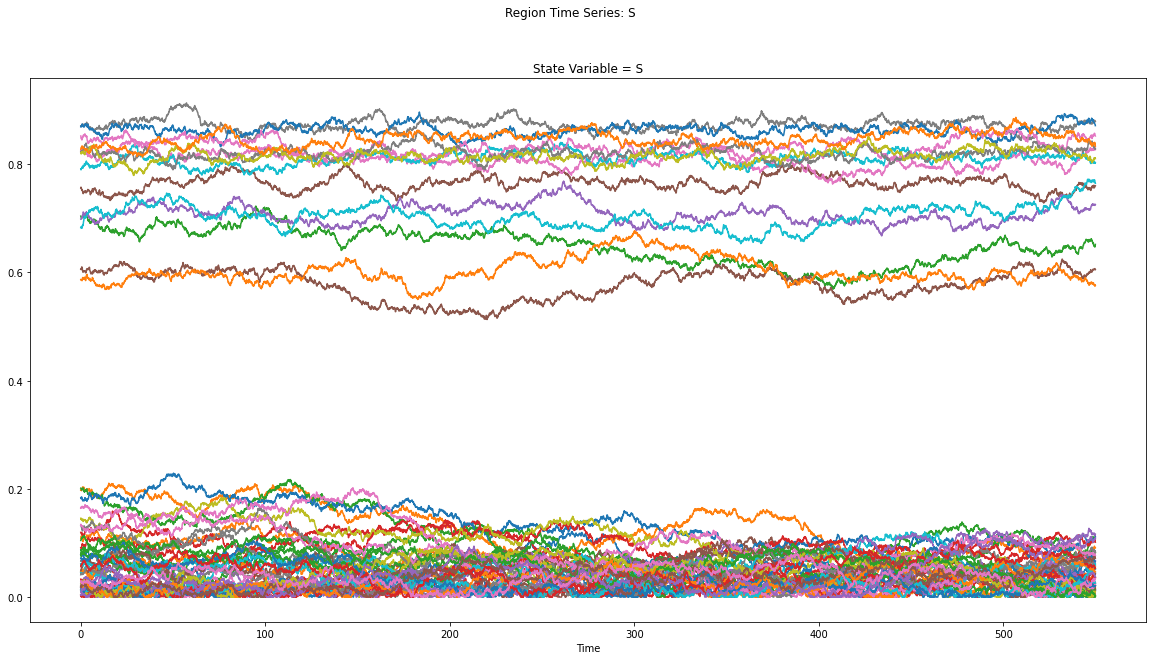

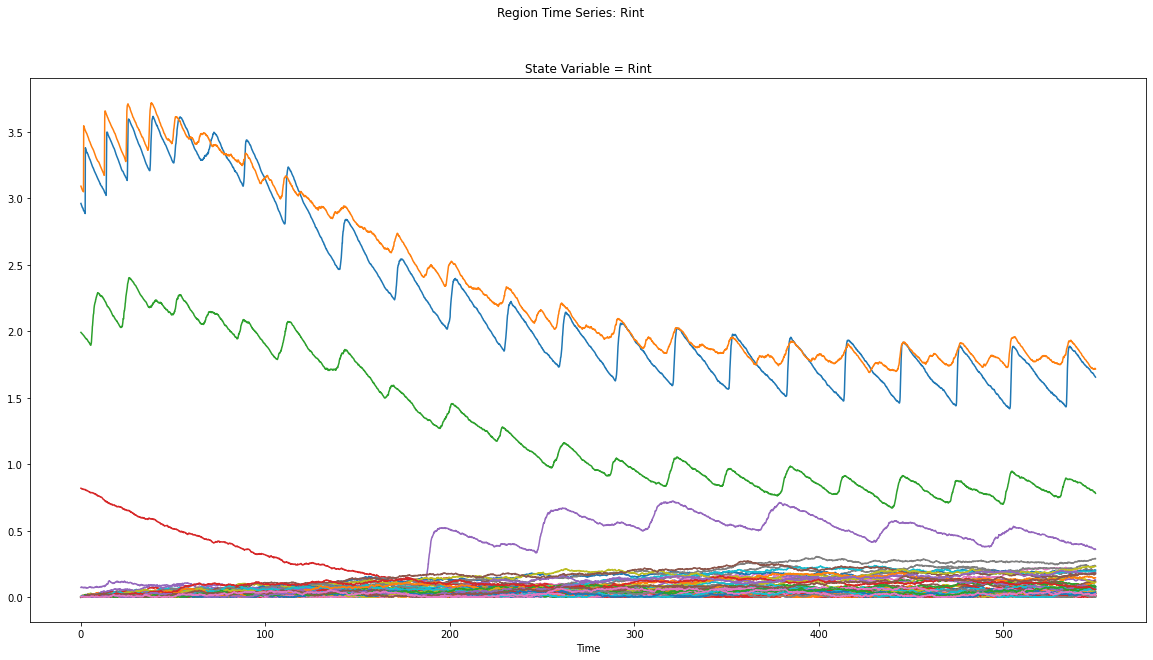

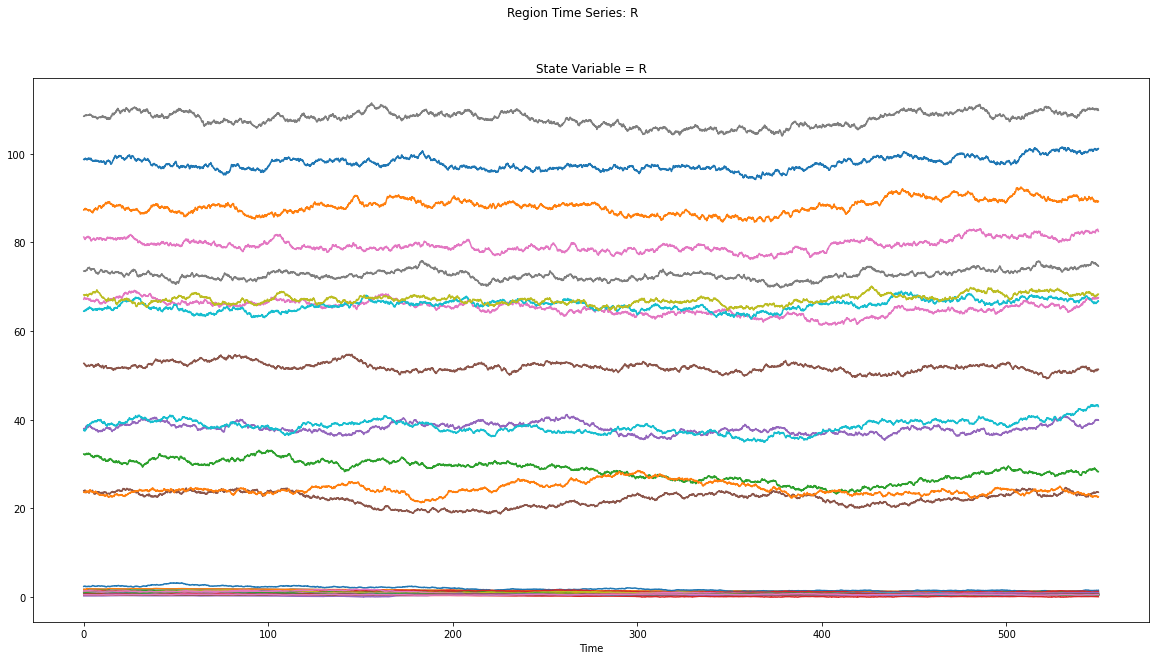

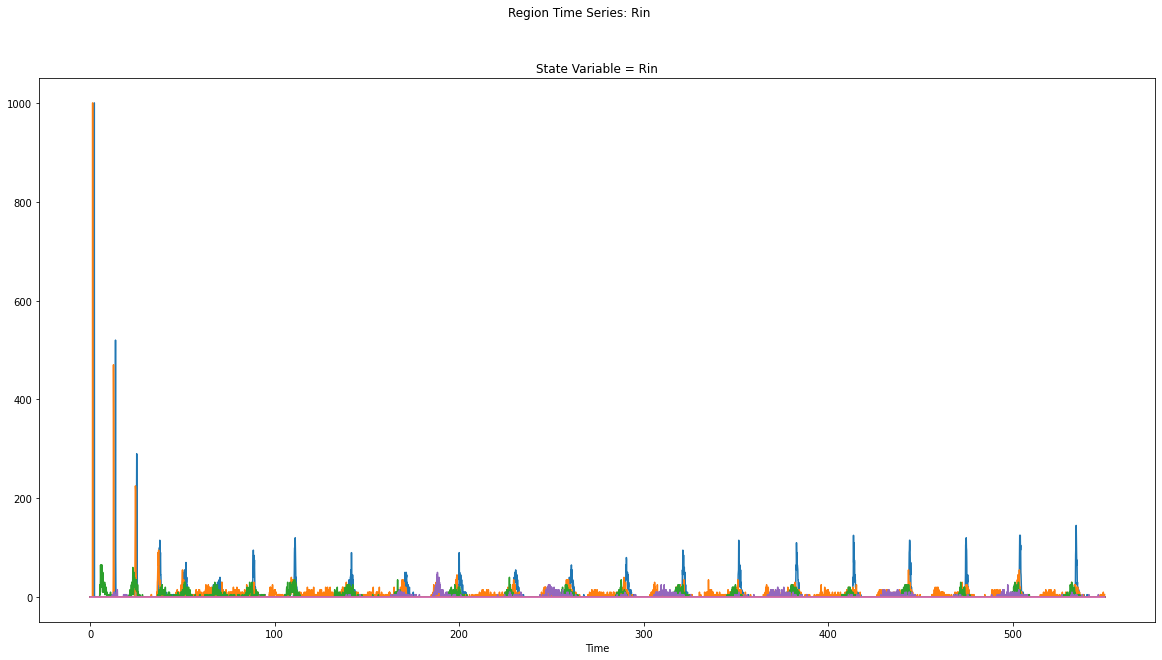

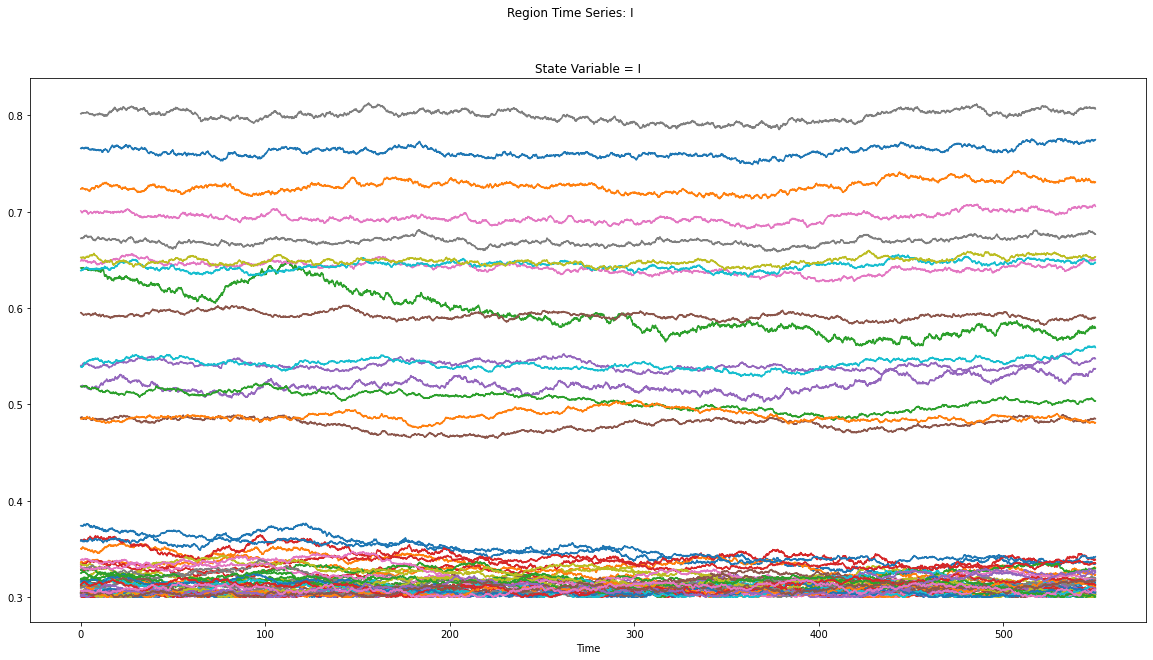

In [18]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [19]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-03-10 14:36:01,906 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:01,923 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:02,620 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:03,239 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:04,100 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:04,822 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


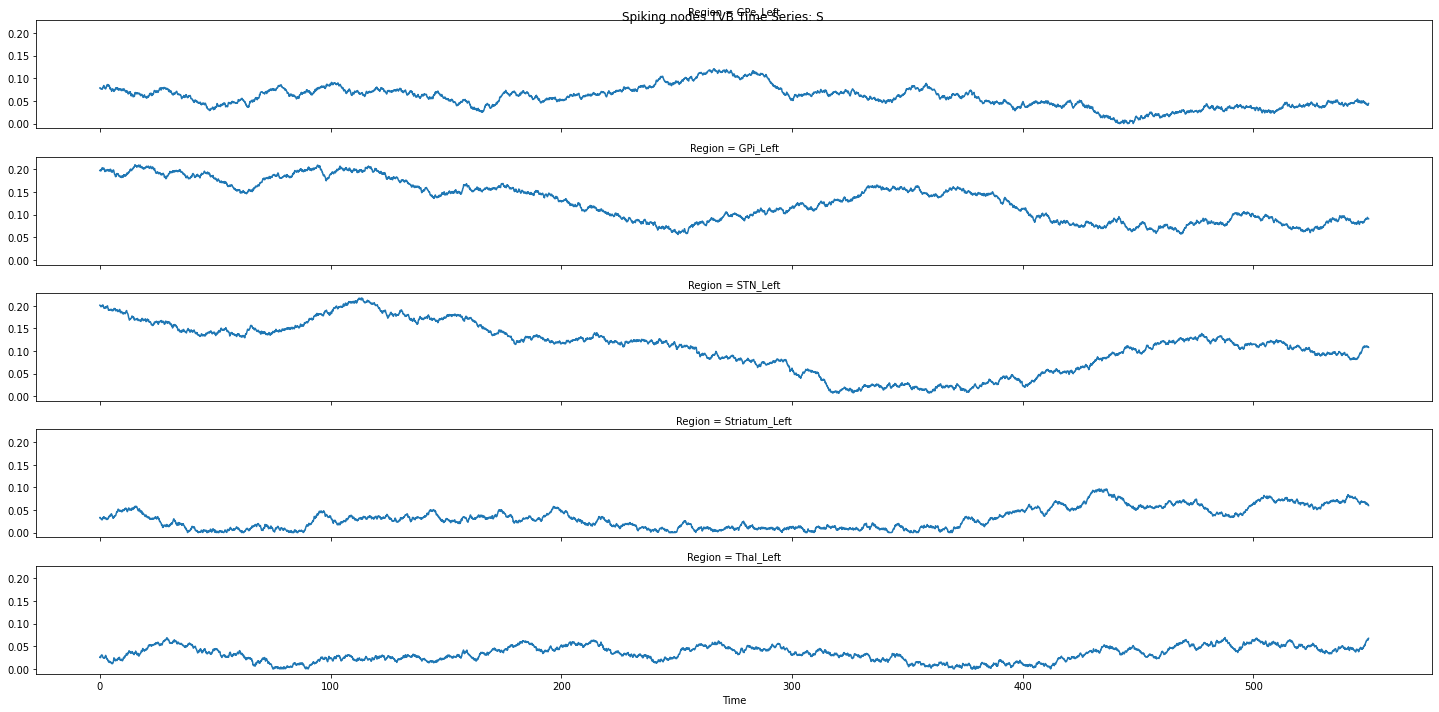

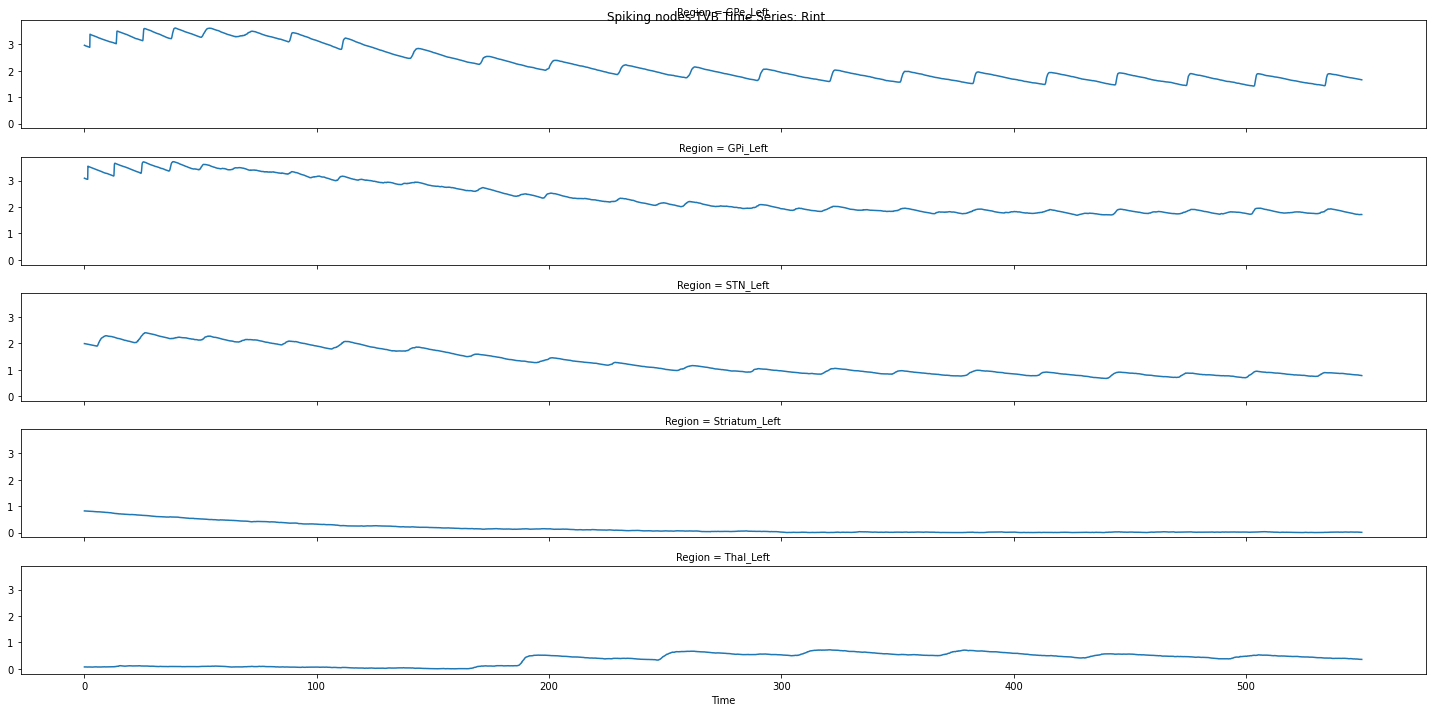

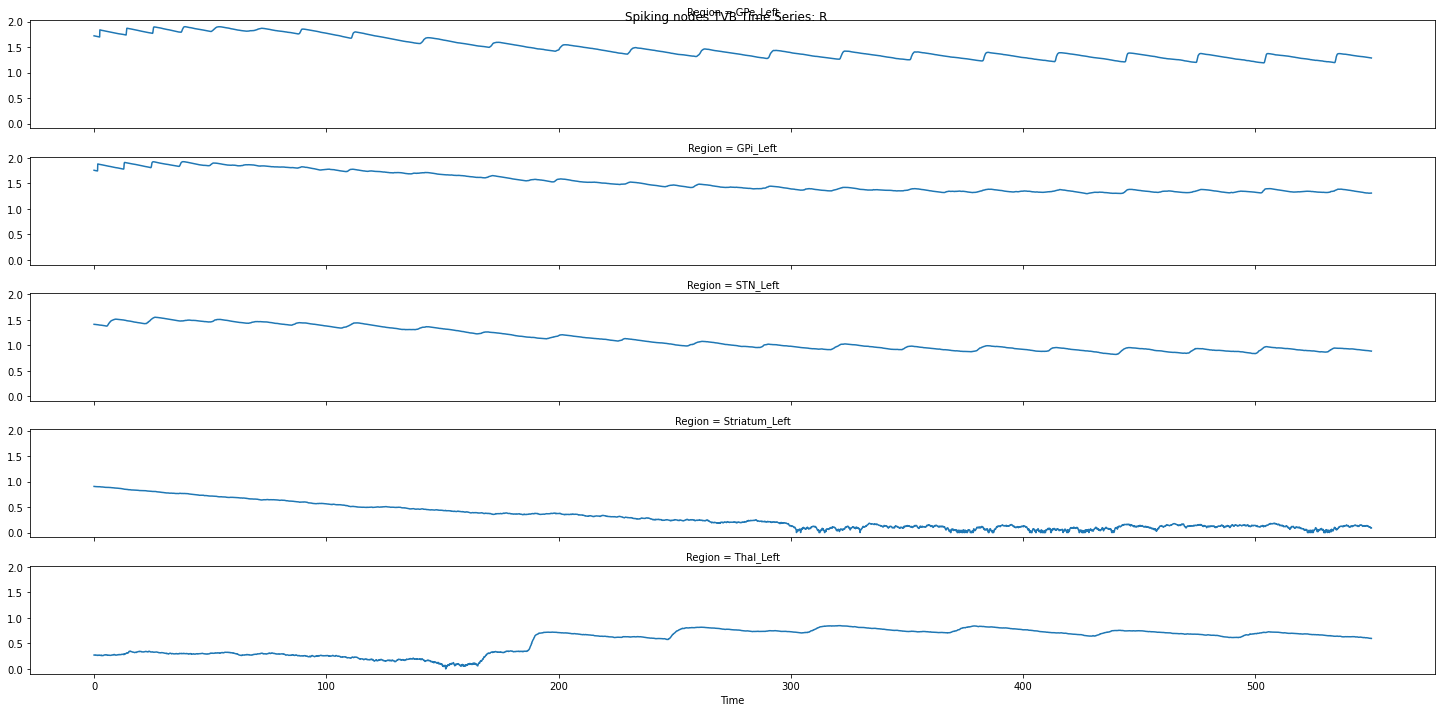

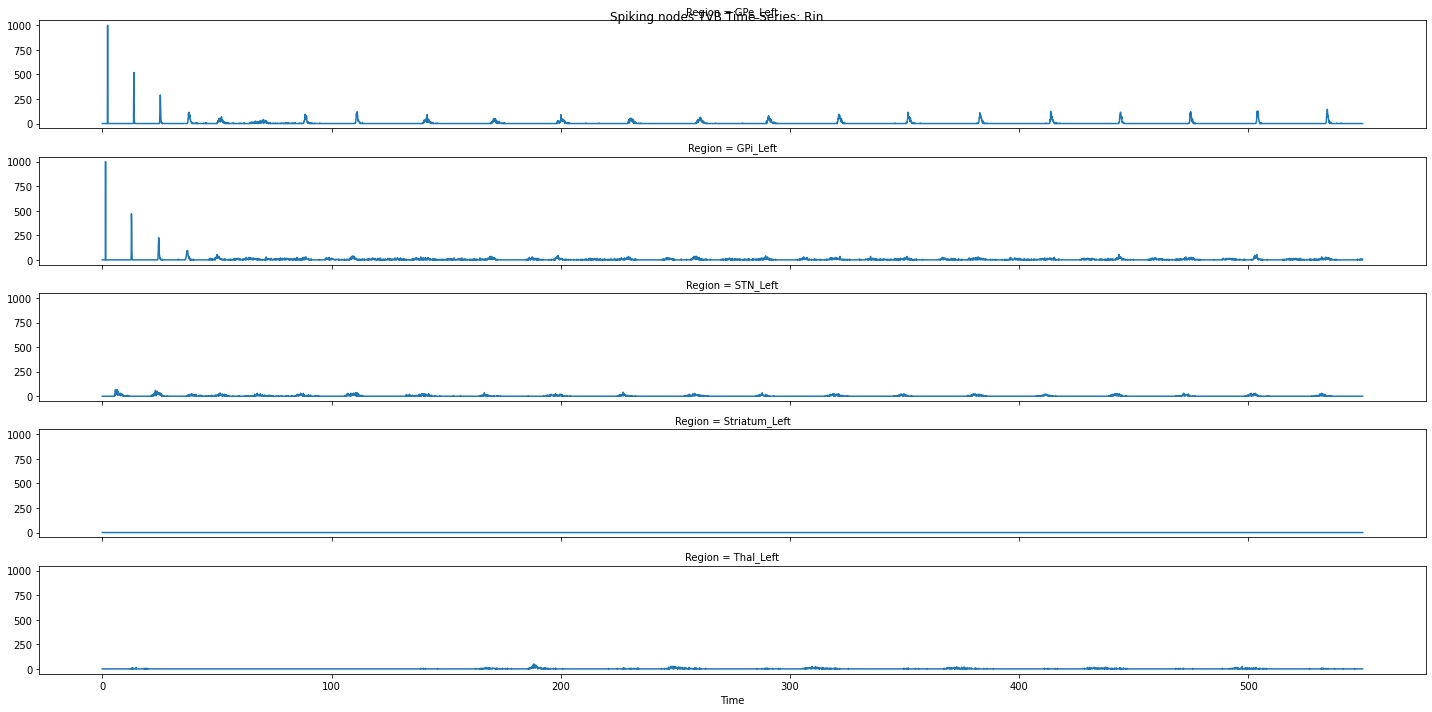

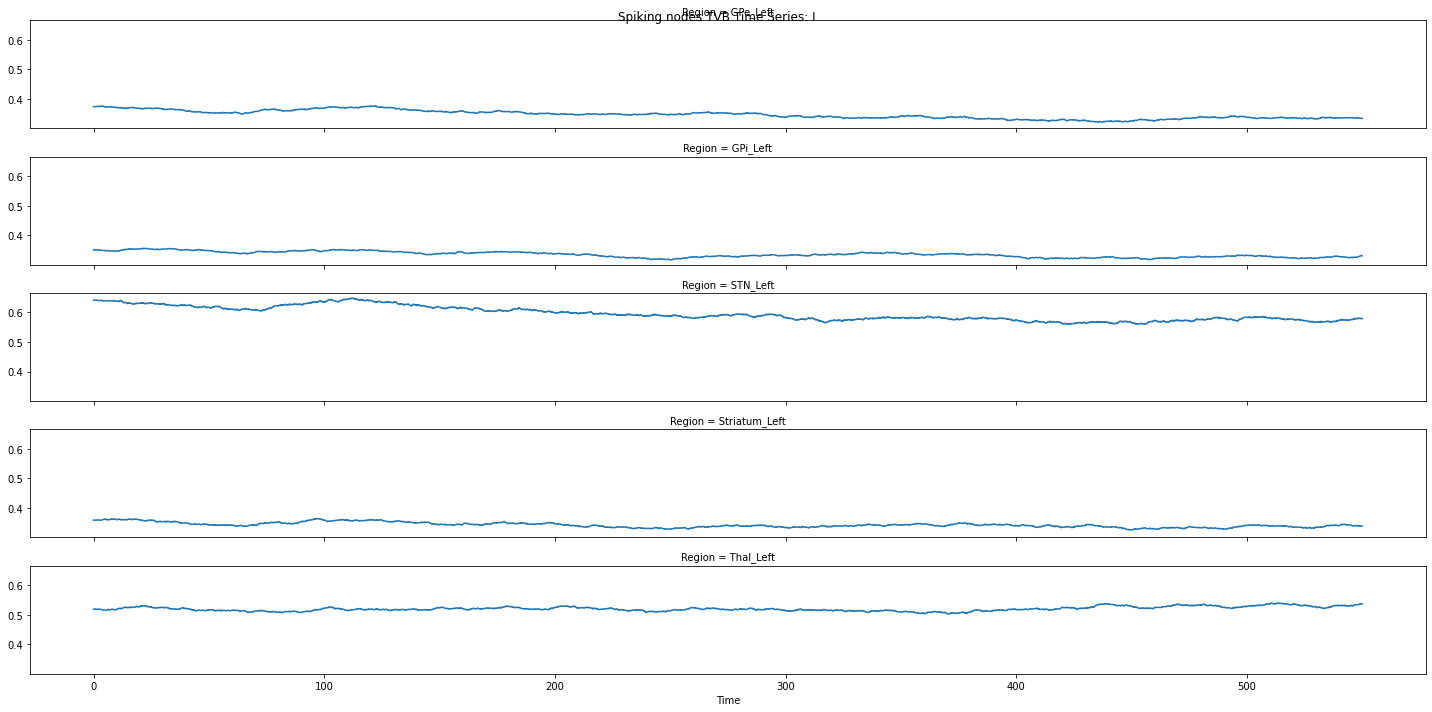

In [20]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [21]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [22]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [23]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [24]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning: Binning discarded 11 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))
/home/docker/env/neurosci/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/docker/env/neurosci/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 18.87775544,         nan,  9.26853704],
       [34.98997982, 36.97394775,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.        ,         nan],
       [        nan,         nan,         nan,  0.        ,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,  1.        ,         nan,
          -0.03707539],
         [        nan,         nan,         nan,         nan,
                  nan],
 

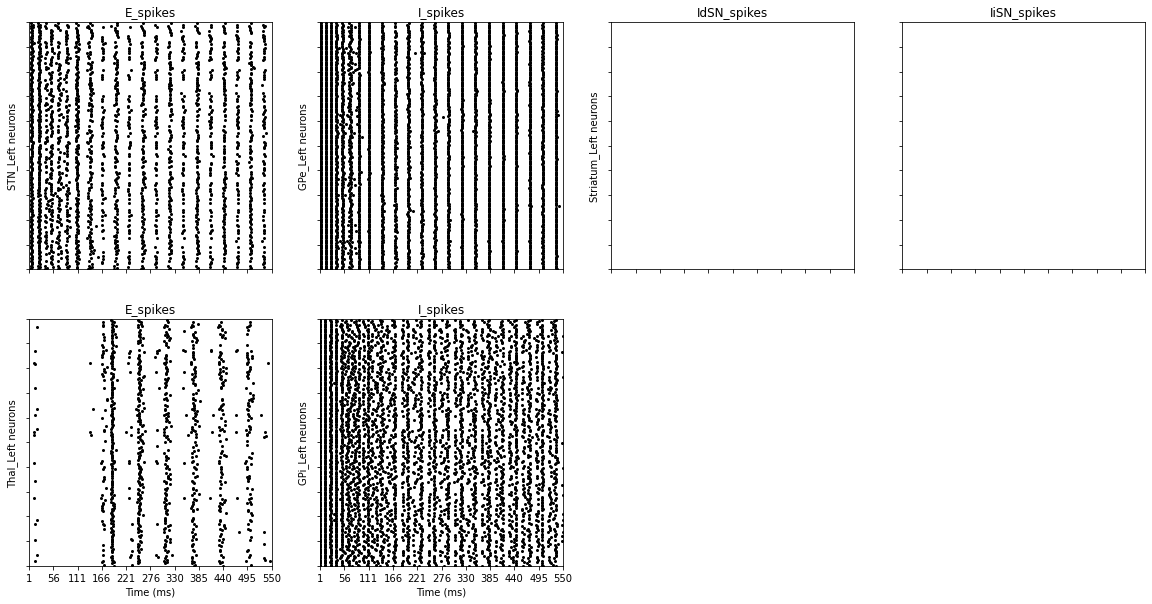

<Figure size 432x288 with 0 Axes>

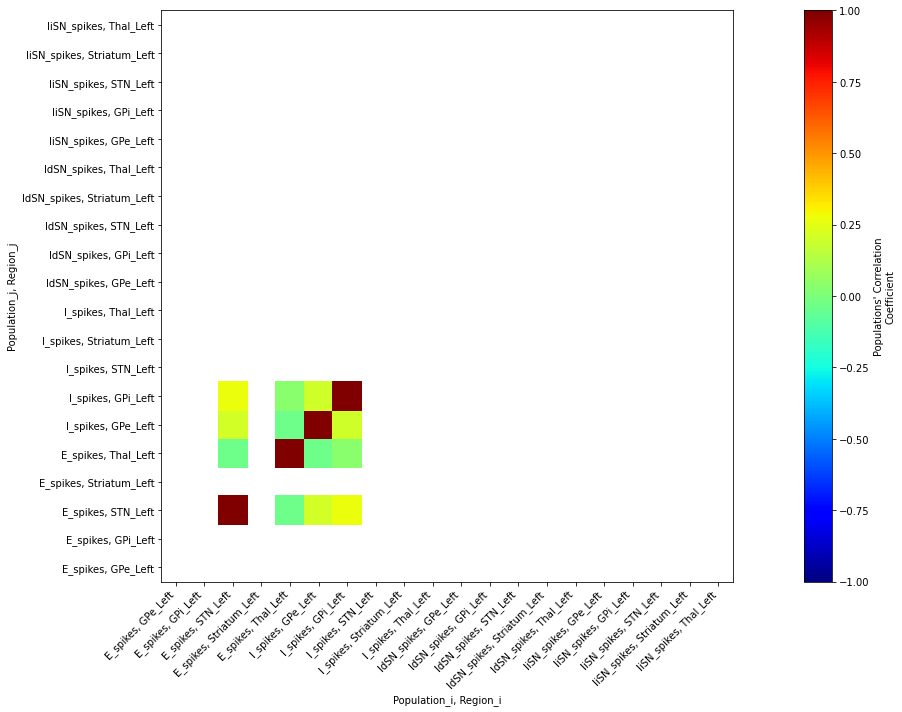

In [25]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], # rates=spikes_res["mean_rate_time_series"],
                                  figsize=FIGSIZE) #  
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [26]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))

Mean spike rates:
E - STN_Left: 18.8778
E - Thal_Left: 9.26854
I - GPe_Left: 34.99
I - GPi_Left: 36.9739
IdSN - Striatum_Left: 0
IiSN - Striatum_Left: 0


In [27]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-03-10 14:36:15,028 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-03-10 14:36:15,028 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-03-10 14:36:15,065 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 14:36:15,065 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 14:36:15,077 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-03-10 14:36:15,077 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy

2021-03-10 14:36:15,170 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[194.4  375.25 438.85 170.45 233.6  376.25 502.7  188.15 248.6  309.2
 368.8  432.45 166.95 193.2  250.   312.9  375.   438.55  14.8  168.4
 191.05 248.7  307.3  368.9  429.85 492.55 546.5  188.35 248.85 312.95
 534.8  188.1  248.4  308.6  369.6  532.2  186.95 230.45 292.65 370.3
 440.75 498.8  187.75 248.1  309.95  19.05 169.15 231.1  288.95 325.55
 378.6  434.65 500.55 188.15 249.1  313.2  188.3  234.15 315.85 373.7
 432.8  495.05 167.75 189.45 248.2  307.9  371.4  433.6  495.8  191.05
 254.1  187.4  247.25 307.4  187.75 248.15 309.2  369.75 436.35 168.8
 250.85 308.85 369.7  431.05 187.95 248.3  308.65 371.65 532.85 189.1
 254.65 320.5  437.55 189.45 251.4  311.25  14.75 188.3  233.6  308.15
 368.7  430.7  500.35 188.75 230.8  320.9  379.2  439.25 189.55 251.5
 313.3  372.65 502.8  189.25 250.35 312.4  372.2 

2021-03-10 14:36:15,187 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0   1   1   1   1   2   2   2   2   2   3   3   3   3   3   3
   4   4   4   4   4   4   4   4   4   5   5   5   5   6   6   6   6   6
   7   7   7   7   7   7   8   8   8   9   9   9   9   9   9   9   9  11
  11  11  12  12  12  12  12  12  13  13  13  13  13  13  13  14  14  15
  15  15  16  16  16  16  16  17  17  17  17  17  18  18  18  18  18  19
  19  19  19  20  20  20  21  21  21  21  21  21  21  22  22  22  22  22
  23  23  23  23  23  24  24  24  24  24  25  25  26  26  26  27  27  27
  27  27  27  28  28  29  29  29  29  29  30  30  30  30  30  30  31  31
  31  31  32  32  32  32  32  33  33  33  33  34  34  34  34  34  34  34
  34  35  35  35  36  36  36  36  36  36  36  37  37  37  37  37  37  37
  38  38  38  38  39  39  39  39  40  41  41  41  42  42  42  43  43  43
  43  43  44  44  

2021-03-10 14:36:15,302 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 14:36:15,302 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 14:36:15,310 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-03-10 14:36:15,310 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-03-10 14:36:15,319 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[] !

2021-03-10 14:36:15,319 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[] !

2021-03-10 14:36:15,339 - WARNING - tvb_multiscale.core.

2021-03-10 14:36:15,871 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 14:36:15,871 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 14:36:15,884 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population_i' 'Population_j' 'Region_i' 'Region_j'] !

2021-03-10 14:36:15,884 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population_i' 'Population_j' 'Region_i' 'Region_j'] !

2021-03-10 14:36:15,923 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[        nan         nan  

2021-03-10 14:36:15,936 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 14:36:15,936 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 14:36:15,946 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 14:36:15,946 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 14:36:15,958 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-10 14:36:15,958 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-10 14:36:15,970 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

2021-03-10 14:36:18,523 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:19,915 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:21,199 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:22,404 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:23,624 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:24,722 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:36:25,891 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

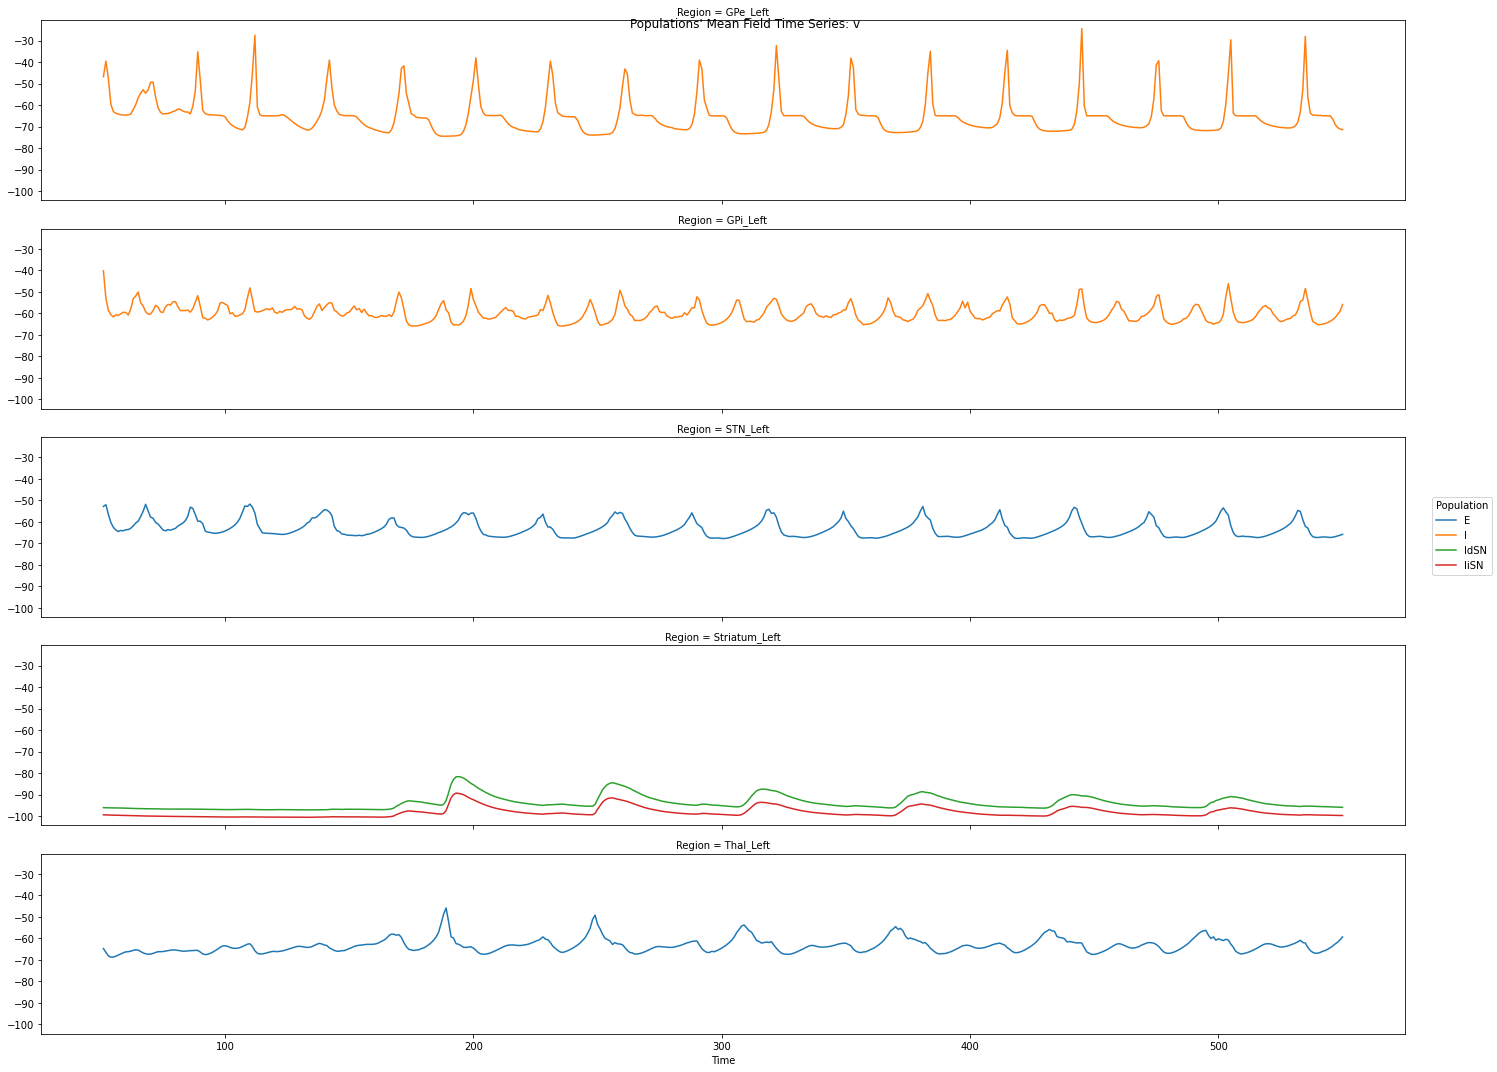

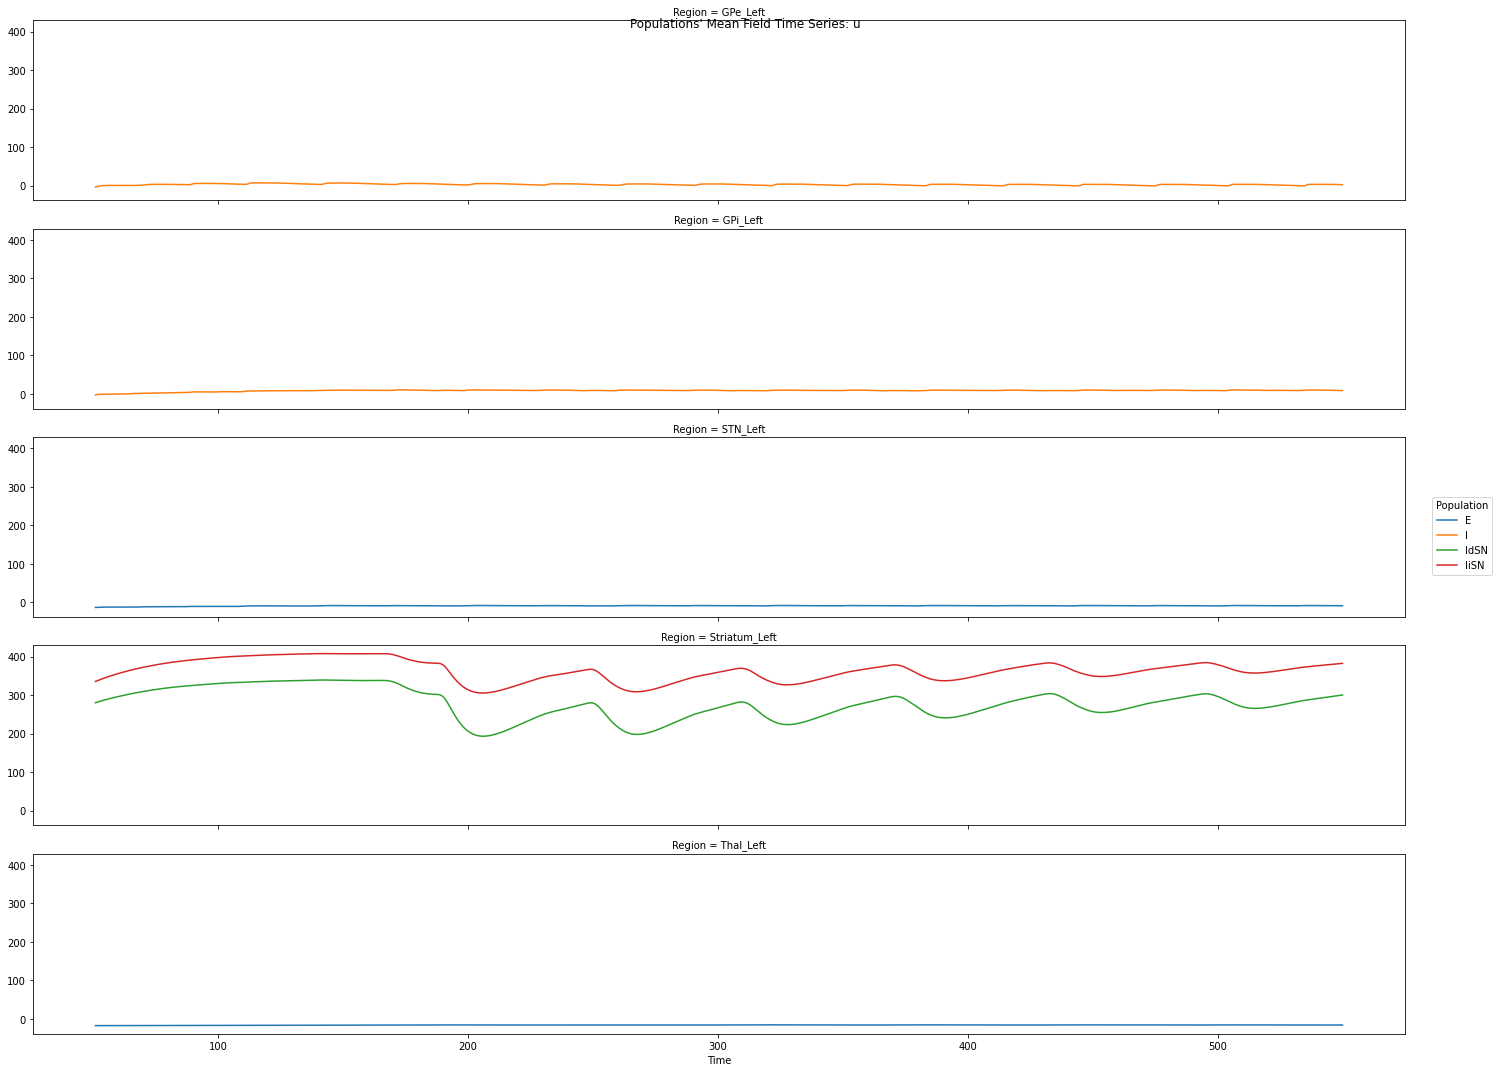

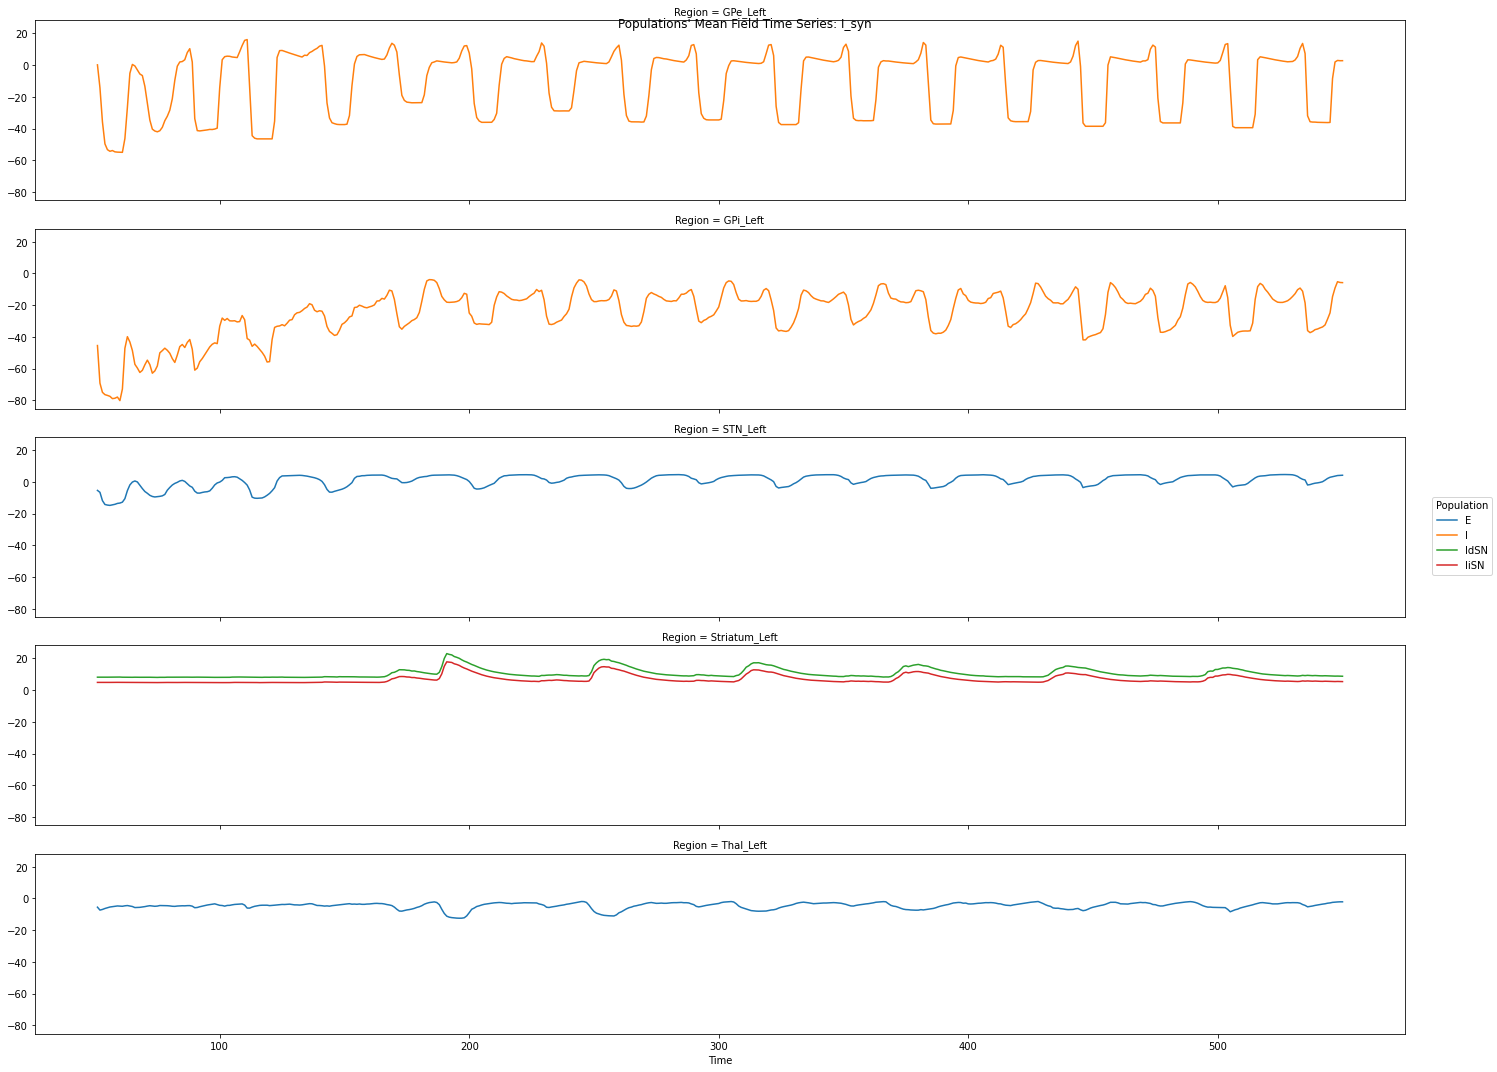

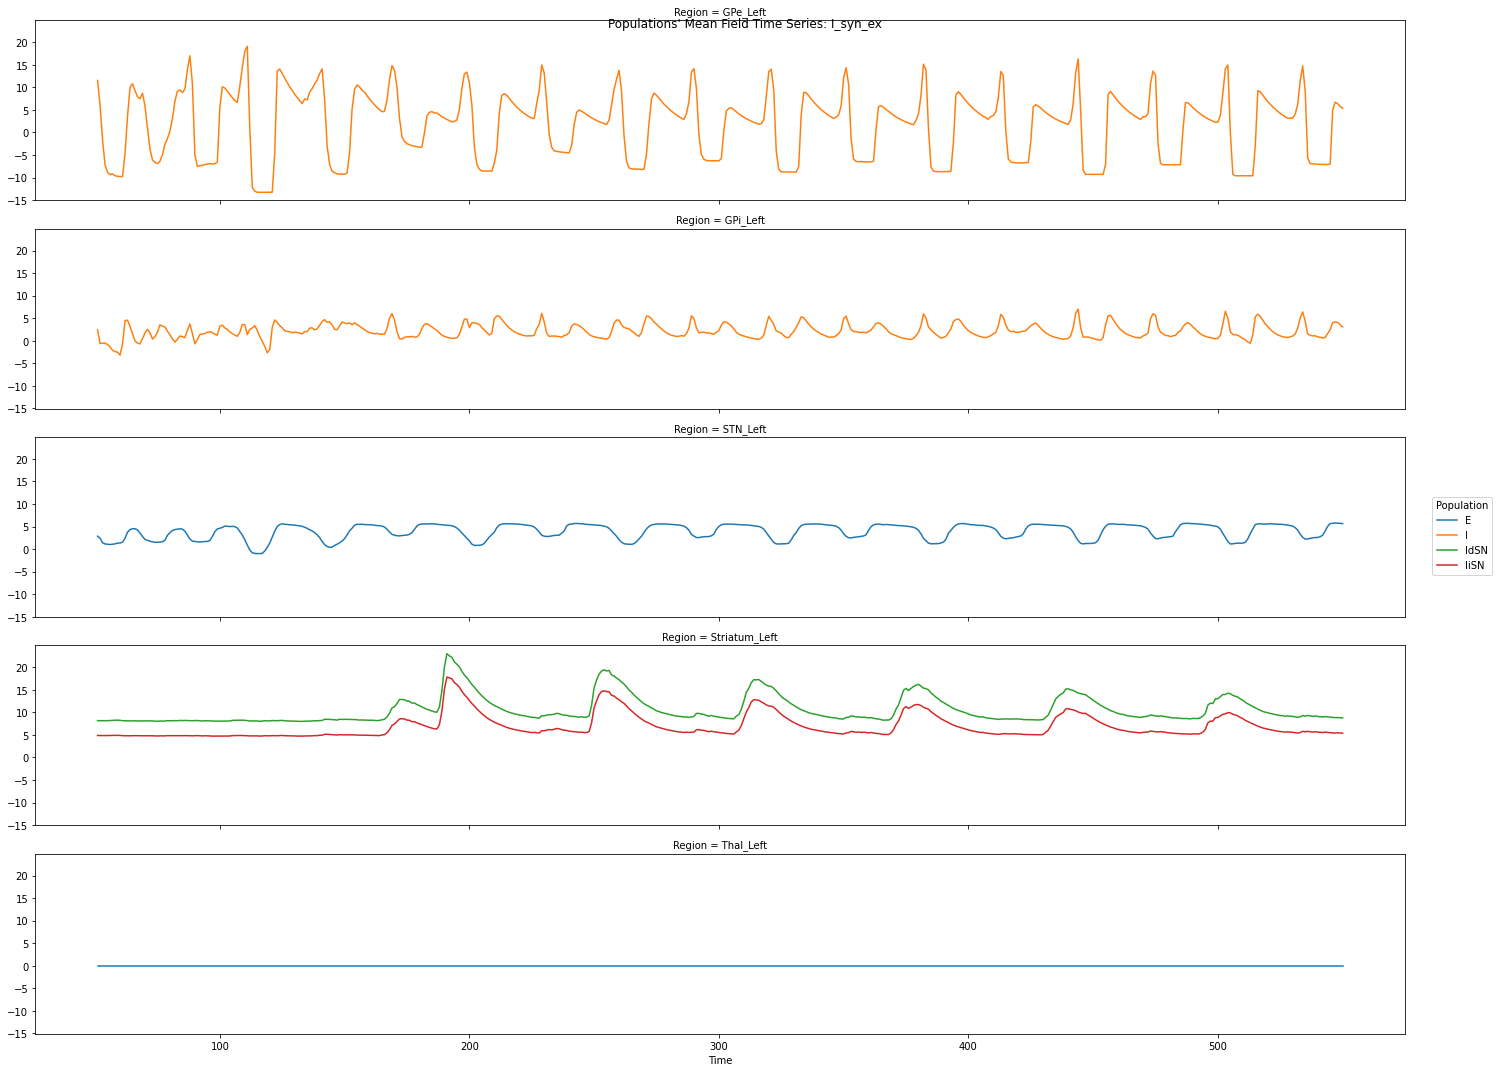

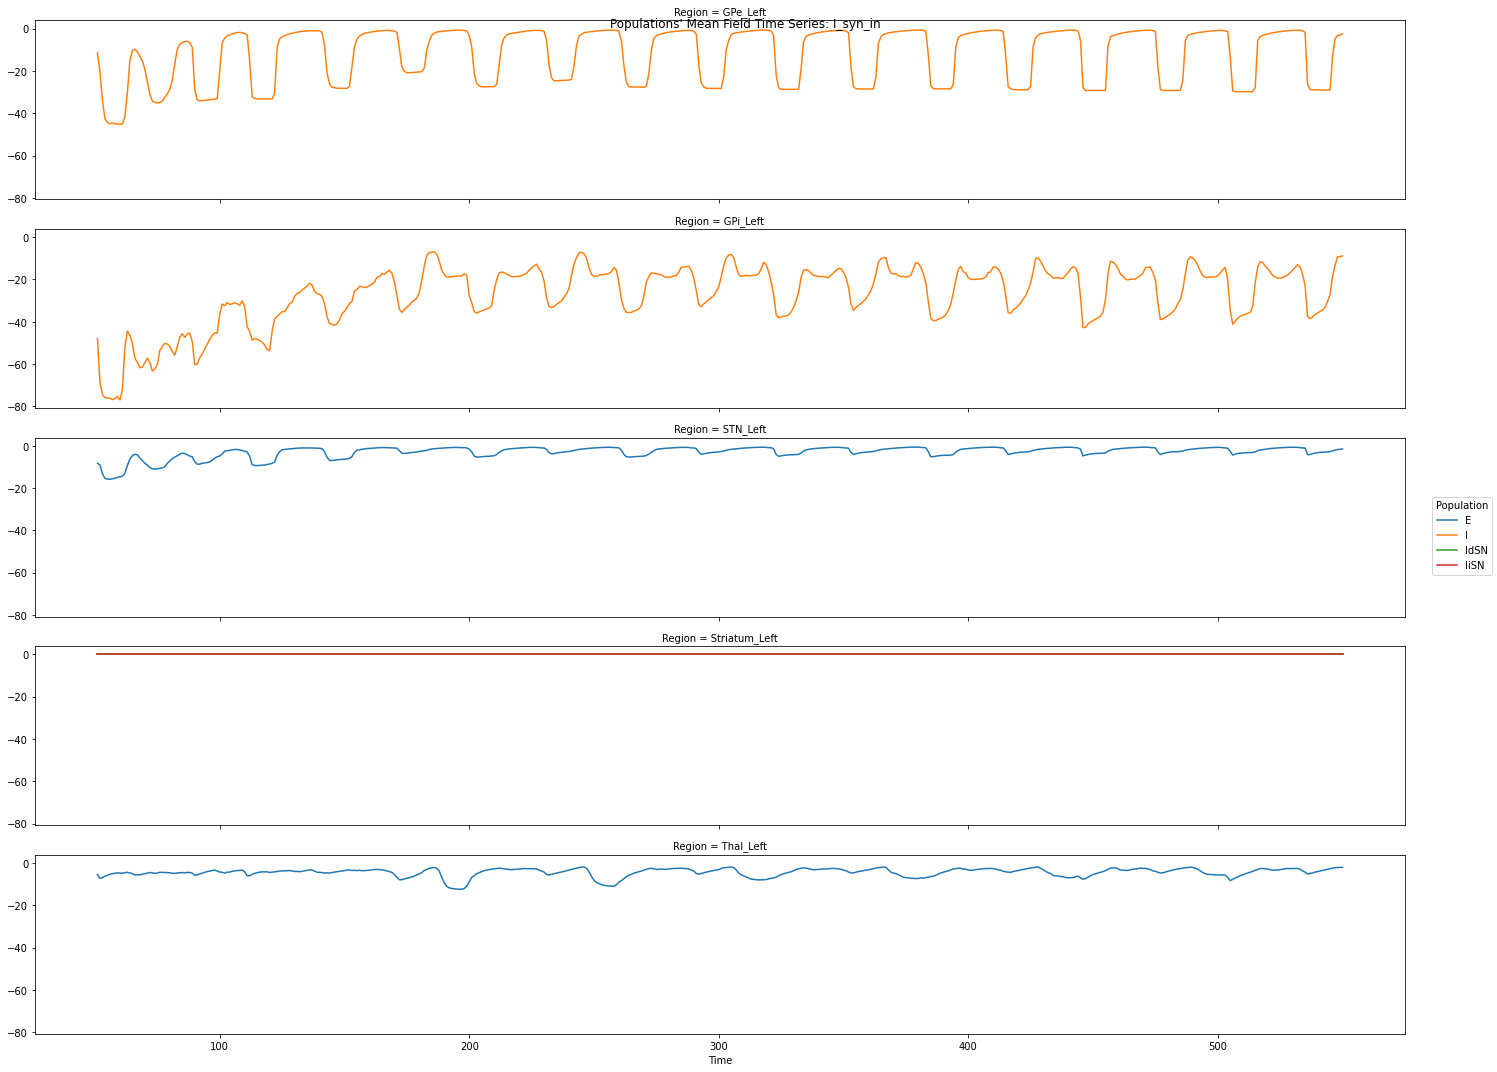

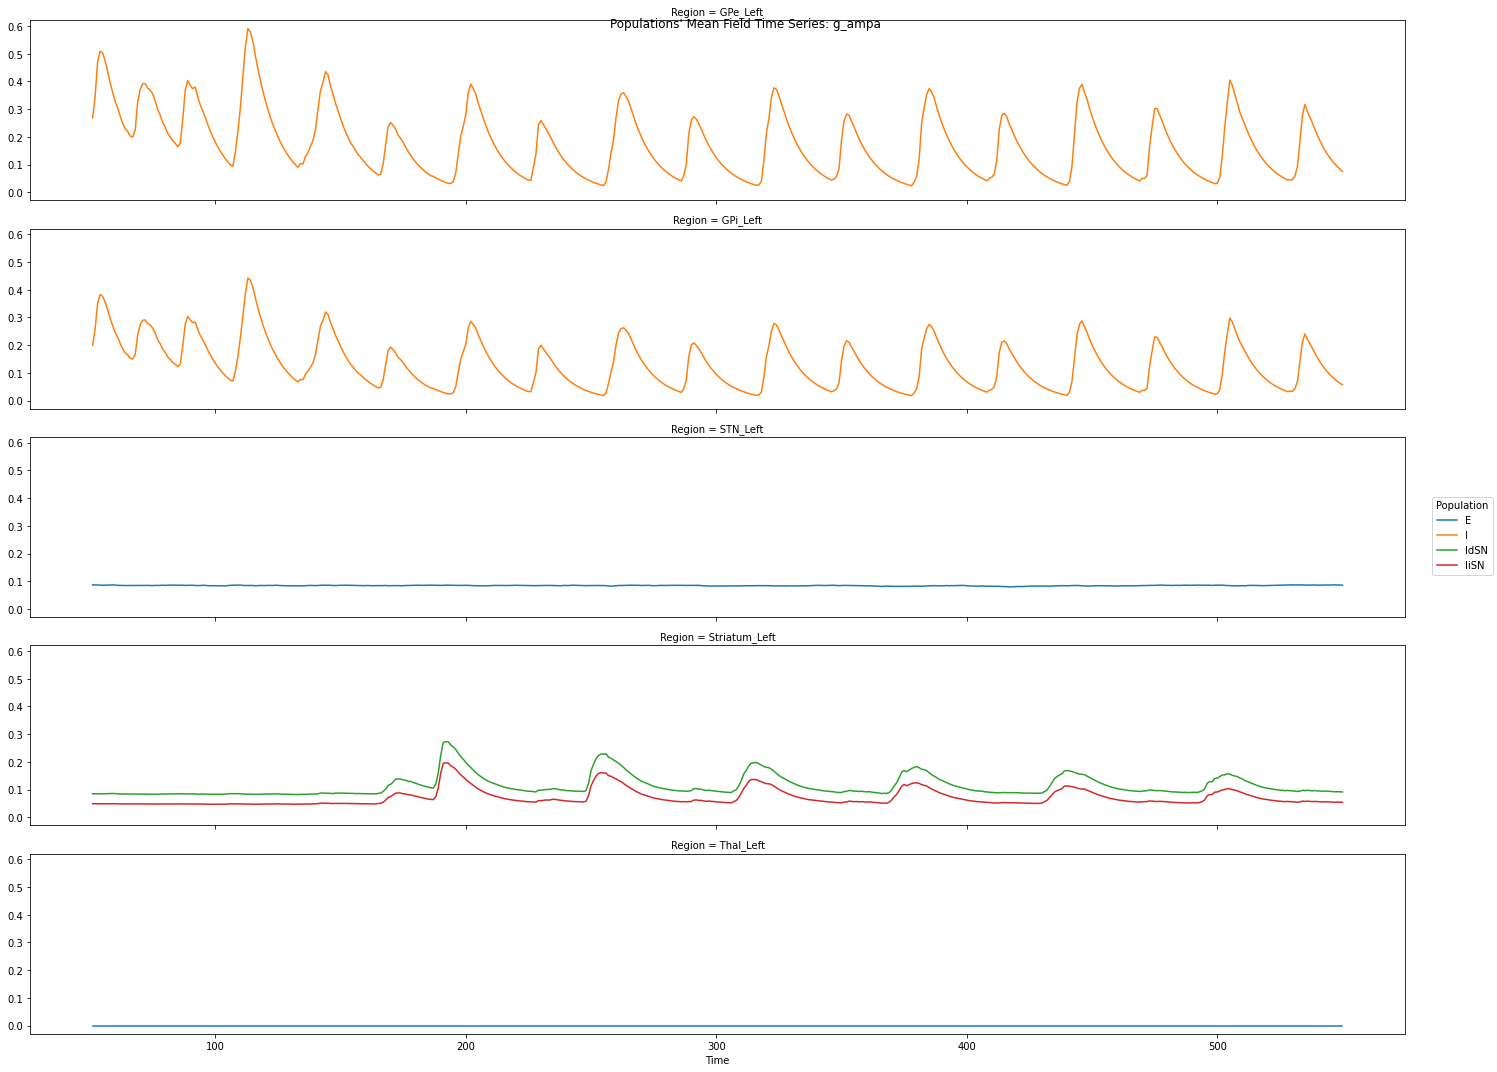

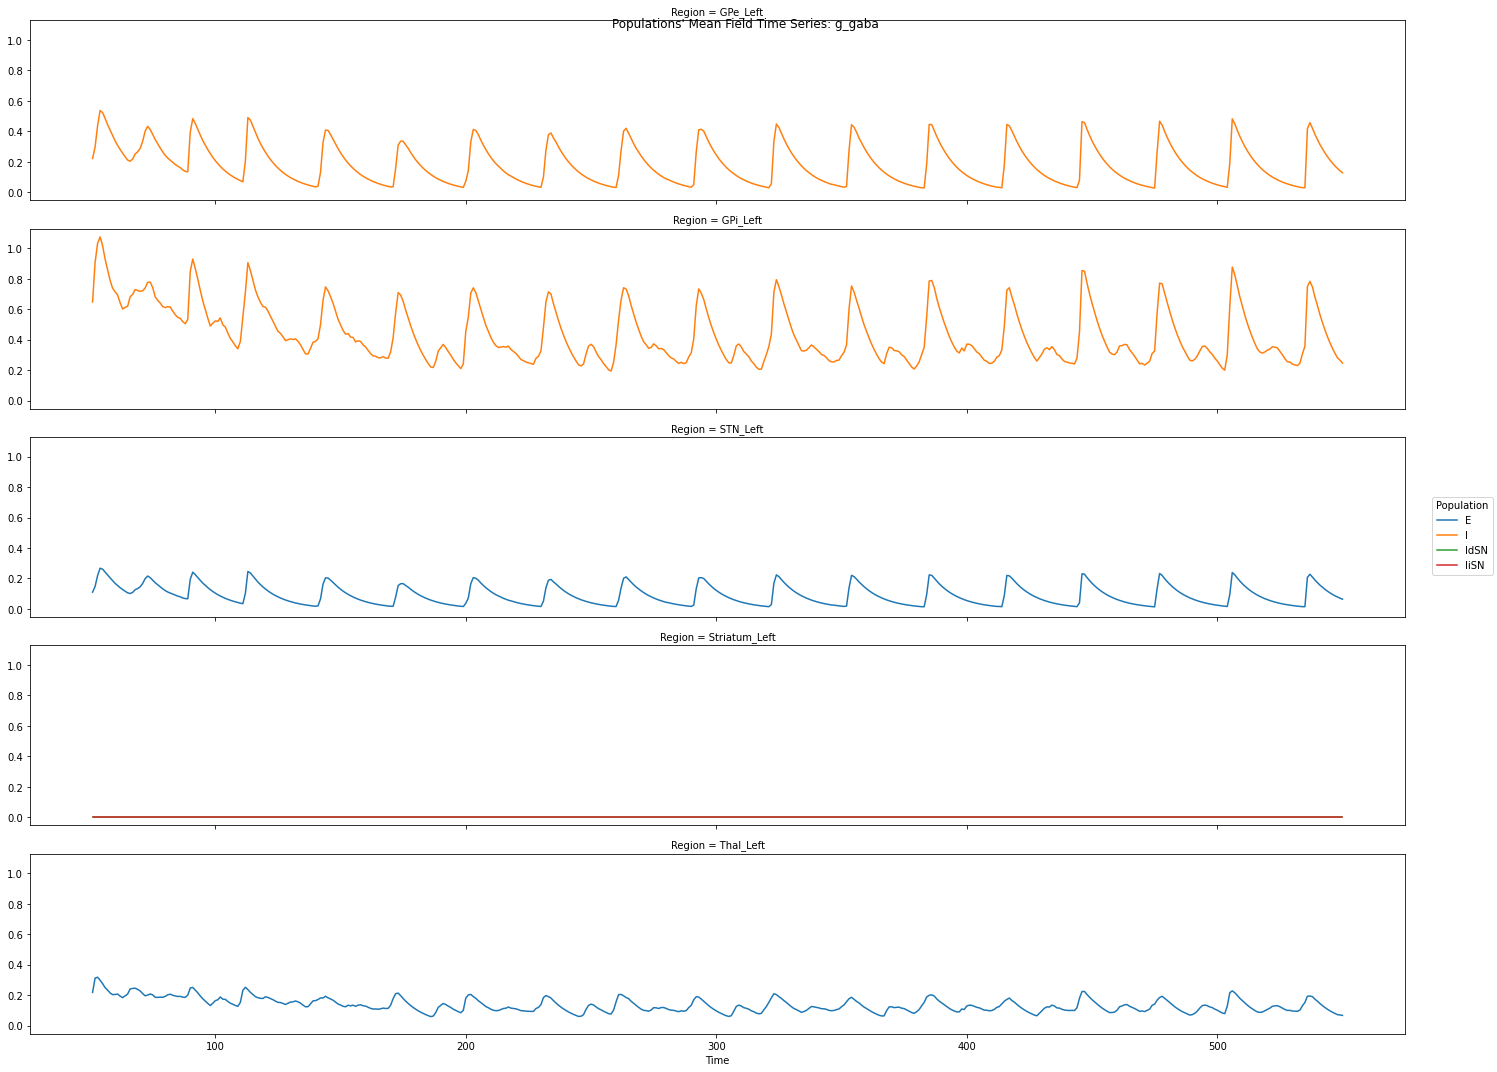

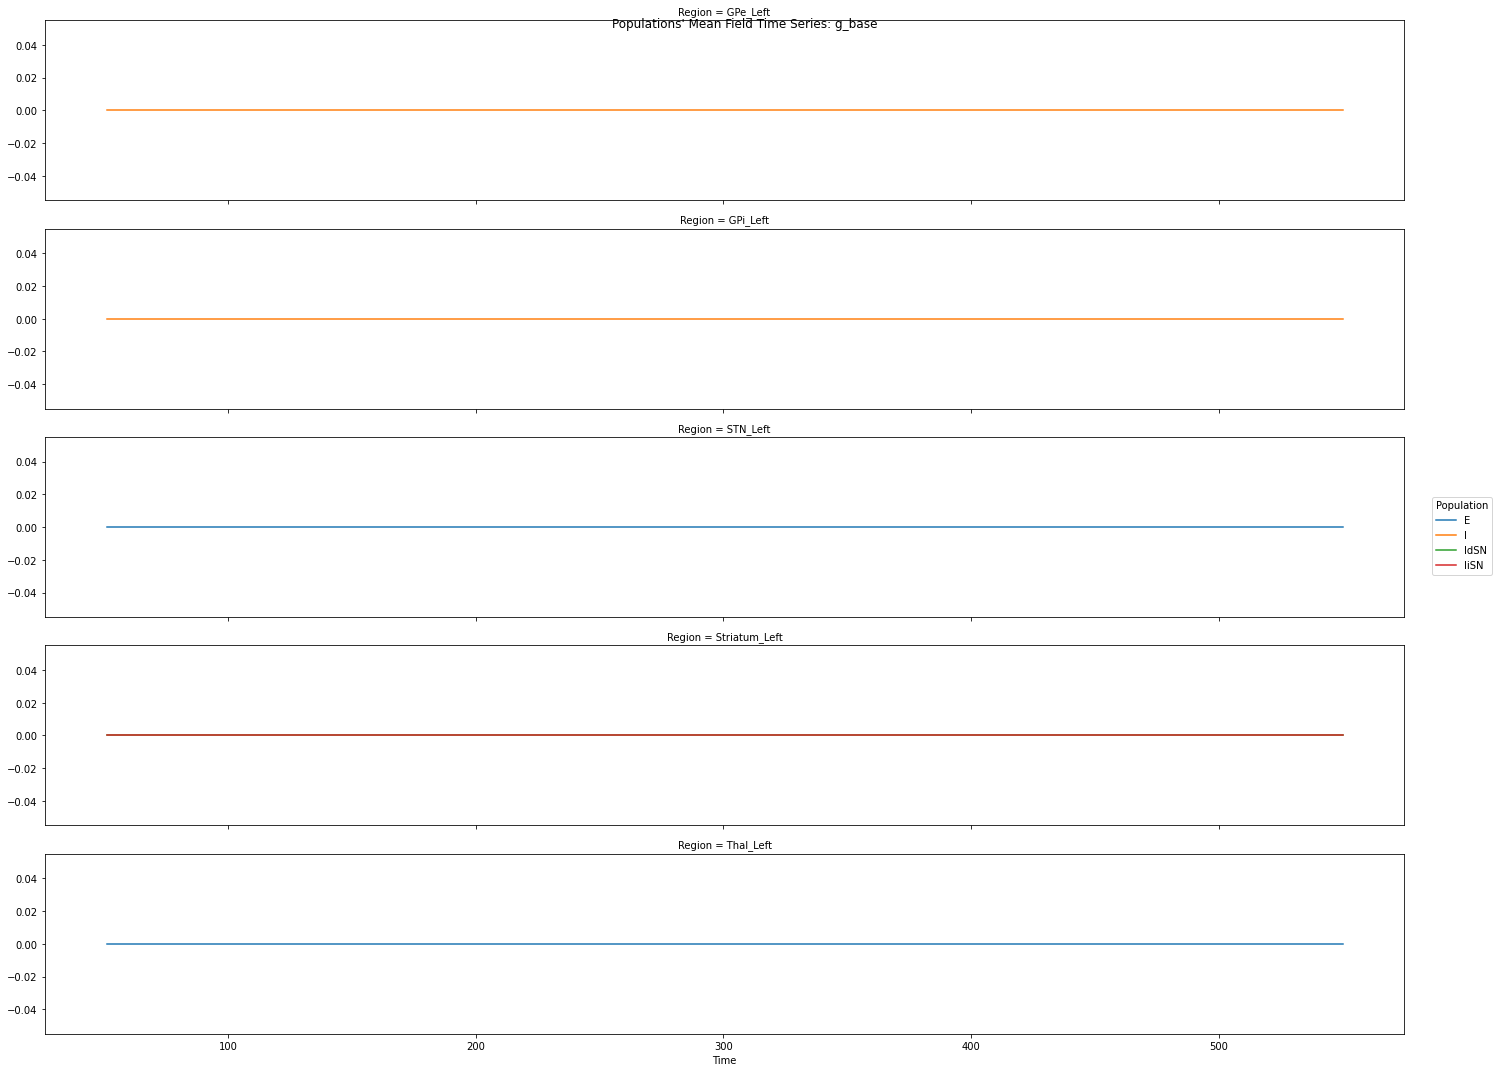

In [28]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [29]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [30]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [31]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868

In [32]:
print("Configured connections:\n")

print("Within node's connections:")
for iP, pop in enumerate(ann_model_builder.populations_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP+1, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for iP, pop in enumerate(ann_model_builder.nodes_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP + 5, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
    
print("\nEffective connections:")
conns = ["GPeGPe", "GPiGPi", "dSNdSN", "iSNiSN", # "CtxICtxI", "CtxECtxI", "CtxICtxE", 
         "dSNGPi" , "iSNGPe", "GPeGPi", "GPiThal", "GPeSTN", "ThaldSN", "ThaliSN", 
         "STNGPe", "STNGPi"] # ,"CtxThal", "CtxSTN", "CtxdSN", "CtxiSN"
for iC, (name, proj) in enumerate(zip(conns, 
                                      annarchy_network.annarchy_instance.Global._network[0]["projections"])):
    meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
    p = meanNconns / proj.pre.size
    print("%d. %s: %s w = %g (%g) (%s), effective_probability = %g (%g)" % 
          (iC+1, proj.name, name, proj.w, loadedParams["%s_weights" % name], proj.target,
            p, loadedParams["%s_probs" % name]))  # meanNconns = %g,  meanNconns,

Configured connections:

Within node's connections:
1. I -> I (gaba) = 0.00773167 (p=0.323896): GPeGPe (0.00773167, 0.323896)
2. I -> I (gaba) = 0.0119856 (p=0.317476): GPiGPi (0.0119856, 0.317476)
3. IdSN -> IdSN (gaba) = 0.0081135 (p=0.44881): dSNdSN (0.0081135, 0.44881)
4. IiSN -> IiSN (gaba) = 0.0139626 (p=0.204922): iSNiSN (0.0139626, 0.204922)

Among node's connections:
5. IdSN -> I (gaba) = 0.00913217 (p=0.170292): dSNGPi (0.00913217, 0.170292)
6. IiSN -> I (gaba) = 0.00766353 (p=0.407464): iSNGPe (0.00766353, 0.407464)
7. I -> I (gaba) = 0.0062383 (p=0.323173): GPeGPi (0.0062383, 0.323173)
8. I -> E (gaba) = 0.00665013 (p=0.259374): GPiThal (0.00665013, 0.259374)
9. I -> E (gaba) = 0.00676034 (p=0.184785): GPeSTN (0.00676034, 0.184785)
10. E -> IdSN (ampa) = 0.0122845 (p=0.127913): ThaldSN (0.0122845, 0.127913)
11. E -> IiSN (ampa) = 0.00698403 (p=0.175348): ThaliSN (0.00698403, 0.175348)
12. E -> I (ampa) = 0.0107546 (p=0.411954): STNGPe (0.0107546, 0.411954)
13. E -> I (ampa)

In [33]:
names = ["CtxSTN", "CtxdSN", "CtxiSN"]
weights = np.array([wCtxSTN, wCtxdSN, wCtxiSN])
iweights = np.array([iwCtxSTN, iwCtxdSN, iwCtxiSN])
probs = np.array([pCtxSTN, pCtxdSN, pCtxiSN])
wTVBs = tvb_annarchy_builder.global_coupling_scaling * np.array([iwCtxSTN * wTVBSTNs, iwCtxdSN * wTVBSNs, iwCtxiSN * wTVBSNs]).T
eff_weights = [[], [], []]
eff_probs = [[], [], []]
n_conn = -1
for iC, proj in enumerate(annarchy_network.annarchy_instance.Global._network[0]["projections"][13:]):
    if proj.w < 1:
        n_conn += 1
        i_node = n_conn % 52
        iN = int(np.floor(n_conn / 52).item())
        w = proj.w 
        name = names[iN]
        weight = weights[iN]
        prob = probs[iN]
        eff_weights[iN].append(w)
        meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
        p = meanNconns / proj.pre.size
        eff_probs[iN].append(p)
        print("%d. %s: eff w = %g == %g (exp), eff p = %g ~= %g (exp)" % 
              (n_conn+1, proj.name, w, wTVBs[i_node][iN], p, prob))

print("\nIn total:")
for iN, (name, weight, prob, w, p) in enumerate(zip(names, weights, probs, eff_weights, eff_probs)):
    print("%d. (%d) %s: eff w = %g == %g (exp), eff p = %g (%g) ~= %g (exp)" % 
          (iN+1, len(w), name,  np.sum(w), tvb_annarchy_builder.global_coupling_scaling*weight, np.mean(p), np.std(p), prob))

1. R - Precentral_L -> E: eff w = 0.000171972 == 0.000171972 (exp), eff p = 0.168225 ~= 0.168288 (exp)
2. R - Frontal_Sup_2_L -> E: eff w = 0.000125491 == 0.000125491 (exp), eff p = 0.166033 ~= 0.168288 (exp)
3. R - Frontal_Mid_2_L -> E: eff w = 0.000233218 == 0.000233218 (exp), eff p = 0.168383 ~= 0.168288 (exp)
4. R - Frontal_Inf_Oper_L -> E: eff w = 9.13025e-06 == 9.13025e-06 (exp), eff p = 0.166967 ~= 0.168288 (exp)
5. R - Frontal_Inf_Tri_L -> E: eff w = 6.98051e-05 == 6.98051e-05 (exp), eff p = 0.167825 ~= 0.168288 (exp)
6. R - Frontal_Inf_Orb_2_L -> E: eff w = 7.48565e-05 == 7.48565e-05 (exp), eff p = 0.168217 ~= 0.168288 (exp)
7. R - Rolandic_Oper_L -> E: eff w = 6.87951e-06 == 6.87951e-06 (exp), eff p = 0.1699 ~= 0.168288 (exp)
8. R - Supp_Motor_Area_L -> E: eff w = 6.1215e-05 == 6.1215e-05 (exp), eff p = 0.169325 ~= 0.168288 (exp)
9. R - Olfactory_L -> E: eff w = 8.64428e-07 == 8.64428e-07 (exp), eff p = 0.169217 ~= 0.168288 (exp)
10. R - Frontal_Sup_Medial_L -> E: eff w = 4.3

88. R - Precuneus_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.195942 ~= 0.195239 (exp)
89. R - Paracentral_Lobule_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196675 ~= 0.195239 (exp)
90. R - Heschl_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.194433 ~= 0.195239 (exp)
91. R - Temporal_Sup_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.195908 ~= 0.195239 (exp)
92. R - Temporal_Pole_Sup_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.19505 ~= 0.195239 (exp)
93. R - Temporal_Mid_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196058 ~= 0.195239 (exp)
94. R - Temporal_Pole_Mid_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196442 ~= 0.195239 (exp)
95. R - Temporal_Inf_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.19545 ~= 0.195239 (exp)
96. R - Cerebelum_Crus1_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.195292 ~= 0.195239 (exp)
97. R - Cerebelum_Crus2_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.1934 ~= 0.195239 (exp)
98. R - Cerebelum_3_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.192858 ~= 0.195239 (exp)
99. R - Cereb

In [34]:
rates = []
spikes = {}
for iR, region in enumerate(tvb_annarchy_model.tvb_to_spikeNet_interfaces[0].keys()):
    monitor = tvb_annarchy_model.tvb_to_spikeNet_interfaces[0][region]._record
    if spikes.get(region, False) == False:
        spikes[region] = monitor.get("spike").copy()
    spike_times, ranks = monitor.raster_plot(spikes[region].copy())
    if len(ranks):
        eff_spike_times = np.array(spike_times)[np.where(spike_times > transient)]
        rate = len(eff_spike_times) / np.unique(ranks).size / (simulation_length - transient) * 1000.0
    else:
        rate = 0.0
    rates.append(rate)
    print("%s rate = %g ~= %g (exp)" % (region, rate, TVBrate[iR]))
total_rate = np.sum(rates)
print("mean rate = %g (%g) ~= %g (exp)" % (np.mean(rates), total_rate /52, TVBrate.mean()))

Precentral_L rate = 51.3667 ~= 51.8154 (exp)
Frontal_Sup_2_L rate = 65.12 ~= 64.9674 (exp)
Frontal_Mid_2_L rate = 106.327 ~= 107.718 (exp)
Frontal_Inf_Oper_L rate = 2.2459 ~= 0.867855 (exp)
Frontal_Inf_Tri_L rate = 65.3033 ~= 65.8307 (exp)
Frontal_Inf_Orb_2_L rate = 97.8933 ~= 97.695 (exp)
Rolandic_Oper_L rate = 2.2439 ~= 0.913165 (exp)
Supp_Motor_Area_L rate = 28.5233 ~= 28.2574 (exp)
Olfactory_L rate = 2.23148 ~= 0.715946 (exp)
Frontal_Sup_Medial_L rate = 38.3367 ~= 37.983 (exp)
Frontal_Med_Orb_L rate = 2.04494 ~= 0.637034 (exp)
Rectus_L rate = 79.5767 ~= 79.2743 (exp)
OFCmed_L rate = 73.1467 ~= 72.6446 (exp)
OFCant_L rate = 67.3467 ~= 67.1525 (exp)
OFCpost_L rate = 38.3833 ~= 38.4196 (exp)
OFClat_L rate = 2.64752 ~= 1.79543 (exp)
Insula_L rate = 88.8167 ~= 88.196 (exp)
Cingulate_Ant_L rate = 2.47788 ~= 0.896305 (exp)
Cingulate_Mid_L rate = 2.53797 ~= 1.25448 (exp)
Cingulate_Post_L rate = 2.06452 ~= 0.598188 (exp)
Hippocampus_L rate = 2.12717 ~= 0.634513 (exp)
ParaHippocampal_L rate 